Я вижу два решения:

Для простоты я бы сделал 2 класса датасета
Если нужно кодировать лишь последовательность букв, он и хранит последовательности букв сразу и не хранит коордианты

В обоих случаях декодер оперирует эмбеддингами букв текста

<h3>1. На вход энкодера x, y, t, dx/dt, dy/st, x'', y'', keybard_key_embedding</h3>

**Что делать, если ближайшая клавиша неалфавитная (пунктуация, клавиши-действия)?**

Добавлю для всех неалфавитных клавиш один специальный токен. Хотя, возможно,
лучше добавить отдельный токен для каждой клавиши. Кажется, в кавиатуре схожесть
клавиш определяется тем, насколько часто они встречаются рядом друг с другом.
Тогда может быть важно отличать enter, который близок к бкве `э`, например,
от `caps lock`, который близок к `ф`. Отмечу, что схожесть в данном случае - это
не просто физическое расстояние между клавишами (хотя отчасти и так), но скорее, похожесть
клавиш `a` и `b` означает, что для последовательностей вида `letter1`, `letter2` ... `letterX`, `letterN`
если вероятность, что `letterX` = `a` велика, то вероятность, что `letterX` = `b` тоже велика.


**Где происходит инициализация токенизатора?**
я бы вынес токенезатор вне датасета и передавал бы его в конструктор датасета.


для каждой раскладки свои instance'ы датасета и модели.



<h3> 2. На вход энкодера последовательность клавиш клавиатуры </h3>

Если ближайшая клавиша неалфавитная **пропускать**

**Где происходит инициализация токенизатора?**


один instance датасета и одна модель для всех раскладок.


Реализовывать ли для каждого варианта отдельный токенизатор:

У нас может быть различное количество токенов: в некотоорых раскладках отсутствует символ "ъ", например

Когда датасет содержит лишь одну раскладку, токенизатор должен учесть символы из одной раскладки. Когда датасет содержит несколько раскладок, токенизатор должен учесть символы из всех раскладок.

Кажется, что варьируется только наличие 'ъ' и 'ё'. Во-первых, не ясно нужны ли эти символы. Есть желание заменять 'ё' на 'е', а 'ъ' на 'ь'. 

Кажется, нас совершенно устраивает токенизатор, содержащий все буквы русского языка, включая 'ё' и 'ъ'. Наличие пары лишних токенов незначительно увеличит размер эмбеддинг-матрицы, но не повлияет на обучение модели.

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
### Эксперимент, показывающий, что самый дешевый способ хранения данных - кортеж массивов ###

from typing import Tuple
import array
import json
import sys


DATA_PATH = r"..\data\data_separated_grid\train__default_only_no_errors__2023_10_31__03_26_16.jsonl"

def get_tuppled_tuple(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return (X, Y, T, grid_name), tgt_word

def _get_data_from_json_line(data
                                ) -> Tuple[list, list, list, str]:
    """
    Parses a JSON line and returns a dictionary with data.
    """
    X = array.array('h', data['curve']['x'])
    Y = array.array('h', data['curve']['y'])
    T = array.array('h', data['curve']['t'])

    grid_name = data['curve']['grid_name']   

    tgt_word = data['word'] if 'word' in data else None

    return X, Y, T, grid_name, tgt_word

def _get_dict_data(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return {'x': X, 'y': Y, 't': T, 'grid_name': grid_name, 'tgt_word': tgt_word}

json_data_els = []
dict_data_els = []
tupled_data_els = []
tuppled_tuppled_data_els = []

with open(DATA_PATH, "r", encoding="utf-8") as json_file:
    for i, line in enumerate(json_file):
        json_data_els.append(json.loads(line))
        tupled_data_els.append(_get_data_from_json_line(json_data_els[-1]))
        dict_data_els.append(_get_dict_data(json_data_els[-1]))
        tuppled_tuppled_data_els.append(get_tuppled_tuple(json_data_els[-1]))
        # print(sys.getsizeof(json_data), sys.getsizeof(tupled_data), sys.getsizeof(dict_data))
        # print(dict_data)
        if i > 100_000:
            break

datasets = [json_data_els, dict_data_els, tupled_data_els, tuppled_tuppled_data_els]
print([sys.getsizeof(ds) for ds in datasets])
print([sum(sys.getsizeof(el) for el in ds)/len(ds) for ds in datasets])
print([type(ds[0]) for ds in datasets])

[800984, 800984, 800984, 800984]
[184.0, 184.0, 80.0, 56.0]
[<class 'dict'>, <class 'dict'>, <class 'tuple'>, <class 'tuple'>]


In [38]:
### Эксперимент, показывающий, что самый дешевый способ хранения данных - кортеж массивов ###

from typing import Tuple
import array
import json
import sys


DATA_PATH = r"..\data\data_separated_grid\train__default_only_no_errors__2023_10_31__03_26_16.jsonl"

def get_tuppled_tuple(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return (X, Y, T, grid_name), tgt_word

def _get_data_from_json_line(data
                                ) -> Tuple[list, list, list, str]:
    """
    Parses a JSON line and returns a dictionary with data.
    """
    X = array.array('h', data['curve']['x'])
    Y = array.array('h', data['curve']['y'])
    T = array.array('h', data['curve']['t'])

    grid_name = data['curve']['grid_name']   

    tgt_word = data['word'] if 'word' in data else None

    return X, Y, T, grid_name, tgt_word

def _get_dict_data(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return {'x': X, 'y': Y, 't': T, 'grid_name': grid_name, 'tgt_word': tgt_word}


n_els = 100_000

json_data_els = [None] * n_els
dict_data_els = [None] * n_els
tupled_data_els = [None] * n_els
tuppled_tuppled_data_els = [None] * n_els

with open(DATA_PATH, "r", encoding="utf-8") as json_file:
    for i, line in enumerate(json_file):
        if i >= n_els:
            break
        
        json_data = json.loads(line)
        json_data_els[i] = json_data
        tupled_data_els[i] = _get_data_from_json_line(json_data)
        dict_data_els[i] = _get_dict_data(json_data)
        tuppled_tuppled_data_els[i] = get_tuppled_tuple(json_data)
        # print(sys.getsizeof(json_data), sys.getsizeof(tupled_data), sys.getsizeof(dict_data))
        # print(dict_data)


datasets = [json_data_els, dict_data_els, tupled_data_els, tuppled_tuppled_data_els]
print([sys.getsizeof(ds) for ds in datasets])
print([sum(sys.getsizeof(el) for el in ds)/len(ds) for ds in datasets])
print([type(ds[0]) for ds in datasets])

[800056, 800056, 800056, 800056]
[184.0, 184.0, 80.0, 56.0]
[<class 'dict'>, <class 'dict'>, <class 'tuple'>, <class 'tuple'>]


In [29]:
type(json_data_els[0]['curve']['x'])

list

In [5]:
import numpy as np


### Эксперимент, показывающий, что самый дешевый способ хранения данных - кортеж массивов ###

from typing import Tuple
import array
import json
import sys


DATA_PATH = r"..\data\data_separated_grid\train__default_only_no_errors__2023_10_31__03_26_16.jsonl"

def get_tuppled_tuple(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return (X, Y, T, grid_name), tgt_word

def _get_data_from_json_line(data
                                ) -> Tuple[list, list, list, str]:
    """
    Parses a JSON line and returns a dictionary with data.
    """
    X = array.array('h', data['curve']['x'])
    Y = array.array('h', data['curve']['y'])
    T = array.array('h', data['curve']['t'])

    grid_name = data['curve']['grid_name']   

    tgt_word = data['word'] if 'word' in data else None

    return X, Y, T, grid_name, tgt_word

def _get_dict_data(data):
    X, Y, T, grid_name, tgt_word = _get_data_from_json_line(data)
    return {'x': X, 'y': Y, 't': T, 'grid_name': grid_name, 'tgt_word': tgt_word}


n_els = 100_000

json_data_els = np.empty((n_els), dtype=object)
dict_data_els = np.empty((n_els), dtype=object)
tupled_data_els = np.empty((n_els), dtype=tuple)
tuppled_tuppled_data_els = np.empty((n_els), dtype=object)

with open(DATA_PATH, "r", encoding="utf-8") as json_file:
    for i, line in enumerate(json_file):
        if i >= n_els:
            break
        
        json_data = json.loads(line)
        json_data_els[i] = json_data
        tupled_data_els[i] = _get_data_from_json_line(json_data)
        dict_data_els[i] = _get_dict_data(json_data)
        tuppled_tuppled_data_els[i] = get_tuppled_tuple(json_data)
        # print(sys.getsizeof(json_data), sys.getsizeof(tupled_data), sys.getsizeof(dict_data))
        # print(dict_data)


datasets = [json_data_els, dict_data_els, tupled_data_els, tuppled_tuppled_data_els]
print([sys.getsizeof(ds) for ds in datasets])
print([sum(sys.getsizeof(el) for el in ds)/len(ds) for ds in datasets])
print([type(ds[0]) for ds in datasets])

[800112, 800112, 800112, 800112]
[184.0, 184.0, 80.0, 56.0]
[<class 'dict'>, <class 'dict'>, <class 'tuple'>, <class 'tuple'>]


In [8]:
import torch 

def get_dx_dt(X: Iterable,
              T: Iterable) -> torch.Tensor:
    """
    Calculates dx/dt for a list of x coordinates and a list of t coordinates.

    Arguments:
    ----------
    X : torch.tensor
        x (position) coordinates.
    T : torch.tensor
        T[i] = time from the beginning of the swipe corresponding to X[i].
    """
    X, T = (torch.tensor(arr) for arr in (X, T))
    dx_dt = torch.zeros_like(X)
    # dx_dt[1:-1] = (X[2:] - X[:-2]) / (T[2:] - T[:-2])
    dx_dt[1:len(X)-1] = (X[2:len(X)] - X[:len(X)-2]) / (T[2:len(X)] - T[:len(X)-2])

    # Example:
    # x0 x1 x2 x3
    # t0 t1 t2 t3
    # dx_dt[0] = 0
    # dx_dt[1] = (x2 - x0) / (t2 - t0)
    # dx_dt[2] = (x3 - x1) / (t3 - t1)
    # dx_dt[3] = 0

    # if True in torch.isnan(dx_dt):
    #     print(dx_dt)
    #     raise ValueError("dx_dt contains NaNs")

    return dx_dt


a = [1, 2, 3]
b = [3, 4, 5]

get_dx_dt(a,b)

tensor([0, 1, 0])

In [4]:
from dataclasses import dataclass

@dataclass
class Curve:
    x: int
    y: int
    t: int
    char: str

In [25]:
from typing import List, Dict, Tuple, Optional, Set
import json

from tqdm.auto import tqdm


def get_gridname_to_out_of_bounds_coords_dict(
        data_paths: List[str], gridname_to_wh: dict,
        total: Optional[int] = None
        ) -> Dict[str, Set[Tuple[int, int]]]:
    """
    Returns a dictionary with grid names as keys and lists of out of bounds coordinates as values.
    """
    gname_to_out_of_bounds = {gname: set() for gname in gridname_to_wh.keys()}

    for data_path in data_paths:
        with open(data_path, "r", encoding="utf-8") as json_file:
            for line in tqdm(json_file, total=total):
                json_data = json.loads(line)
                curve = json_data['curve']
                grid_name = curve['grid_name']
                w, h = gridname_to_wh[grid_name]
                X, Y = curve['x'], curve['y']
                out_of_bounds = set((x, y) for x, y in zip(X, Y) 
                                    if x < 0 or x >= w or y < 0 or y >= h)
                gname_to_out_of_bounds[grid_name].update(out_of_bounds)
    return gname_to_out_of_bounds

In [26]:
def get_grid(grid_name: str, grids_path: str) -> dict:
    with open(grids_path, "r", encoding="utf-8") as f:
        return json.load(f)[grid_name]

def get_grid_name_to_grid(grid_name_to_grid__path: str) -> dict:
    # In case there will be more grids in "grid_name_to_grid.json"
    grid_name_to_grid = {
        grid_name: get_grid(grid_name, grid_name_to_grid__path)
        for grid_name in ("default", "extra")
    }
    return grid_name_to_grid

if __name__ == "__main__":
    DATA_PATH = r"..\data\data_separated_grid\train__default_only_no_errors__2023_10_31__03_26_16.jsonl"
    GnameToGridPath = r"..\data\data_separated_grid\gridname_to_grid.json"

    gridname_to_grid = get_grid_name_to_grid(GnameToGridPath)

    gname_to_wh = {
        gname: (grid['width'], grid['height']) 
        for gname, grid in gridname_to_grid.items()
    }

    gname_to_out_of_bounds = get_gridname_to_out_of_bounds_coords_dict(
        [DATA_PATH], gname_to_wh, total=6_000_000
    )

 87%|████████▋ | 5237584/6000000 [05:58<00:52, 14616.39it/s]


In [29]:
print(len(gname_to_out_of_bounds['default']), len(gname_to_out_of_bounds['extra']))

62044 0


In [2]:
%load_ext autoreload
%autoreload 2


import json

from dataset import CurveDataset
from transforms import TransformerInputOutputGetter
from nearest_key_lookup import NearestKeyLookup
from tokenizers import ALL_CYRILLIC_LETTERS_ALPHABET_ORD
from tokenizers import KeyboardTokenizerv1, CharLevelTokenizerv2


DATA_PATH = r"..\data\data_separated_grid\train__default_only_no_errors__2023_10_31__03_26_16.jsonl"
VOCAB_PATH = r"..\data\data_separated_grid\voc.txt"
GnameToGridPath = r"..\data\data_separated_grid\gridname_to_grid.json"


def get_grid(grid_name: str, grids_path: str) -> dict:
    with open(grids_path, "r", encoding="utf-8") as f:
        return json.load(f)[grid_name]

def get_grid_name_to_grid(grid_name_to_grid__path: str) -> dict:
    # In case there will be more grids in "grid_name_to_grid.json"
    grid_name_to_grid = {
        grid_name: get_grid(grid_name, grid_name_to_grid__path)
        for grid_name in ("default", "extra")
    }
    return grid_name_to_grid


if __name__ == "__main__":
    gridname_to_grid = get_grid_name_to_grid(GnameToGridPath)

    gridname_to_nkl = {
        gname: NearestKeyLookup(grid, ALL_CYRILLIC_LETTERS_ALPHABET_ORD)
        for gname, grid in gridname_to_grid.items()
    }

    gname_to_wh = {
        gname: (grid['width'], grid['height']) 
        for gname, grid in gridname_to_grid.items()
    }

    kb_tokenizer = KeyboardTokenizerv1()
    word_tokenizer = CharLevelTokenizerv2(VOCAB_PATH)

    transformer_in_out_getter = TransformerInputOutputGetter(
        grid_name_to_nk_lookup=gridname_to_nkl,
        grid_name_to_wh=gname_to_wh,
        kb_tokenizer=kb_tokenizer
        word_tokenizer=word_tokenizer,
        include_time=False,
        include_velocities=True,
        include_accelerations=True
    )

    ds = CurveDataset(DATA_PATH, transformer_in_out_getter)

5237584it [05:25, 16089.62it/s]


In [18]:
(traj_feats, kb_tokens, decoder_in), decoder_out = ds[0]
print(decoder_out.shape == decoder_in.shape)
print(word_tokenizer.decode(decoder_out))
print(word_tokenizer.decode(decoder_in))
print([kb_tokenizer.i2t[i] for i in kb_tokens])
print(traj_feats.shape)
assert traj_feats.shape[0] == kb_tokens.shape[0], f"Different sequence lengths: " \
    "traj_feats.shape[0] = {traj_feats.shape[0]}, kb_tokens.shape[0] = {kb_tokens.shape[0]}"

True
силе<eos>
<sos>силе
['с', 'с', 'с', 'с', 'с', 'с', 'м', 'м', 'и', 'и', 'т', 'т', 'ь', 'ь', 'ь', 'ь', 'л', 'л', 'л', 'л', 'л', 'л', 'л', 'о', 'о', 'н', 'е', 'е', 'е', 'к', 'к']
torch.Size([31, 6])


In [2]:
import pandas as pd

In [6]:
# предполагается, что есть таблица predictors_table

# * predictor_id
# * word_generator_type
# * Generator_call_kwargs_json
# * Model_architecture_name
# * Model_weights_path
# * Grid_name
# * test_preds_path
# * val_preds_path
# * validation_metric

# predictor_id should autoincrement
df = pd.DataFrame(columns=[
    'predictor_id',
    'word_generator_type',
    'generator_call_kwargs_json',
    'model_architecture_name',
    'model_weights_path',
    'grid_name',
    'test_preds_path',
    'val_preds_path',
    'validation_mmr'])

df.to_csv('predictors_table.csv', index=False)

df = pd.read_csv('predictors_table.csv')

df


,predictor_id,word_generator_type,generator_call_kwargs_json,model_architecture_name,model_weights_path,grid_name,test_preds_path,val_preds_path,validation_mmr


In [7]:
print(df.keys())

Index(['predictor_id', 'word_generator_type', 'generator_call_kwargs_json',
       'model_architecture_name', 'model_weights_path', 'grid_name',
       'test_preds_path', 'val_preds_path', 'validation_mmr'],
      dtype='object')


In [8]:
dict = {
    'word_generator_type': ['word_generator_type1', 'word_generator_type2'],
    'generator_call_kwargs_json': ['generator_call_kwargs_json1', 'generator_call_kwargs_json2'],
    'model_architecture_name': ['model_architecture_name1', 'model_architecture_name2'],
    'model_weights_path': ['model_weights_path1', 'model_weights_path2'],
    'grid_name': ['grid_name1', 'grid_name2']
}

df1 = pd.DataFrame(dict)
display(df1)

,word_generator_type,generator_call_kwargs_json,model_architecture_name,model_weights_path,grid_name
0,word_generator_type1,generator_call_kwargs_json1,model_architecture_name1,model_weights_path1,grid_name1
1,word_generator_type2,generator_call_kwargs_json2,model_architecture_name2,model_weights_path2,grid_name2


In [9]:
pd.concat([df, df1], ignore_index = True)

,predictor_id,word_generator_type,generator_call_kwargs_json,model_architecture_name,model_weights_path,grid_name,test_preds_path,val_preds_path,validation_mmr
0,NaN,word_generator_type1,generator_call_kwargs_json1,model_architecture_name1,model_weights_path1,grid_name1,NaN,NaN,NaN
1,NaN,word_generator_type2,generator_call_kwargs_json2,model_architecture_name2,model_weights_path2,grid_name2,NaN,NaN,NaN


In [28]:
import os
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm import tqdm

from model import SwipeCurveTransformer, get_m1_model
from tokenizers import CharLevelTokenizerv2, KeyboardTokenizerv1
from dataset import NeuroSwipeDatasetv3
from word_generators import GreedyGenerator, BeamGenerator
from metrics import get_mmr

In [29]:
IN_KAGGLE = False

if IN_KAGGLE:
    DATA_ROOT = "/kaggle/input/yandex-cup-playground"
    MODELS_DIR = ""
else:
    DATA_ROOT = "../data/data_separated_grid"
    MODELS_DIR = "../data/trained_models/m1"

In [30]:
import pickle

word_tokenizer = CharLevelTokenizerv2(os.path.join(DATA_ROOT, "voc.txt"))

if not IN_KAGGLE:
    word_tokenizer_save_path = os.path.join(DATA_ROOT, "word_tokenizer.pkl")

    with open(word_tokenizer_save_path, 'wb') as f:
        pickle.dump(word_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

    with open(word_tokenizer_save_path, 'rb') as f:
        word_tokenizer = pickle.load(f)

In [31]:
print(word_tokenizer.idx_to_char)

{0: '-', 1: 'а', 2: 'б', 3: 'в', 4: 'г', 5: 'д', 6: 'е', 7: 'ж', 8: 'з', 9: 'и', 10: 'й', 11: 'к', 12: 'л', 13: 'м', 14: 'н', 15: 'о', 16: 'п', 17: 'р', 18: 'с', 19: 'т', 20: 'у', 21: 'ф', 22: 'х', 23: 'ц', 24: 'ч', 25: 'ш', 26: 'щ', 27: 'ъ', 28: 'ы', 29: 'ь', 30: 'э', 31: 'ю', 32: 'я', 33: '<eos>', 34: '<unk>', 35: '<pad>', 36: '<sos>'}


In [32]:
def get_grid(grid_name: str, grids_path: str) -> dict:
    with open(grids_path, "r", encoding="utf-8") as f:
        return json.load(f)[grid_name]

In [36]:
grid_name = "extra"
sample_data = os.path.join(DATA_ROOT, f"valid__in_train_format__{grid_name}_only.jsonl")
grid_path =  os.path.join(DATA_ROOT, "gridname_to_grid.json")

grid = get_grid(grid_name, grid_path)
kb_tokenizer = KeyboardTokenizerv1()
word_tokenizer = CharLevelTokenizerv2(os.path.join(DATA_ROOT, "voc.txt"))


dataset = NeuroSwipeDatasetv3(
    data_path = sample_data,
    gridname_to_grid= {grid_name: grid},
    kb_tokenizer = kb_tokenizer,
    word_tokenizer = word_tokenizer,
    include_time = False,
    include_velocities = True,
    include_accelerations = True,
    total = 9_416
)

In [ ]:
dataset[0]

In [12]:
# full train dataset before adding nearest_kb_label:
# ----------------------------------
# 16.2GB RAM (when data stored as torch tensors)
# when stored as lists 17Gb is 61%
# when data stored as python arrays with dtype short: 4.8GB RAM


# Now:
# ----
# 9.3 Gb RAM

In [468]:
i = 40
(xyt, kb_tokens, dec_in_char_seq, traj_pad_mask, word_pad_mask), dec_out_char_seq = dataset[i]
print(xyt.shape, kb_tokens.shape, dec_in_char_seq.shape, traj_pad_mask.shape, word_pad_mask.shape, dec_out_char_seq.shape)

torch.Size([299, 6]) torch.Size([299]) torch.Size([35]) torch.Size([299]) torch.Size([35]) torch.Size([35])


In [469]:
with np.printoptions(threshold=1000000):
    print(dataset._nearest_kb_label_dict['default'][:3])

[['й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й' 'й'
  'й' 'й' 'й' 'й' 'й' 'й' 'й' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф'
  'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф'
  'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф'
  'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф'
  'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 'ф' 

In [470]:
# def get_mask(max_seq_len: int):
#     """
#     Returns a mask for the decoder transformer.
#     """
#     mask = torch.triu(torch.ones(max_seq_len, max_seq_len), diagonal=1)
#     mask = mask.masked_fill(mask == 1, float('-inf'))
#     return mask

# mask = get_mask(5)
# print(mask)

# >>>
# tensor([[0., -inf, -inf, -inf, -inf],
#         [0., 0., -inf, -inf, -inf],
#         [0., 0., 0., -inf, -inf],
#         [0., 0., 0., 0., -inf],
#         [0., 0., 0., 0., 0.]])

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
!python model_tests.py

Encoder out shape correct
Decoder out shape correct


In [11]:
word_char_tokenizer = CharLevelTokenizerv1(os.path.join(DATA_ROOT, "voc.txt"))

In [475]:
word_char_tokenizer.tokenize("троллейбус")

(tensor([36, 19, 17, 15, 12, 12,  6, 10,  2, 20, 18, 33, 34, 34, 34, 34, 34, 34,
         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]),
 tensor([False, False, False, False, False, False, False, False, False, False,
         False, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True]))

In [476]:
print(word_char_tokenizer.char_to_idx.keys())

dict_keys(['-', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', '<eos>', '<pad>', '<unk>', '<sos>'])


In [477]:
len(word_char_tokenizer.tokenize('информационно-телекоммуникационной')[0])

36

In [478]:
len(word_char_tokenizer.tokenize('информационно')[0])

36

In [479]:
word_char_tokenizer.decode(word_char_tokenizer.tokenize('информационно-телекоммуникационной')[0])

'<sos>информационно-телекоммуникационной<eos>'

In [480]:
word_char_tokenizer.max_word_len - 1

35

In [12]:
def prepare_batch_v1(x, y, device):
    (xyt, kb_tokens, dec_in_char_seq, traj_pad_mask, word_pad_mask), dec_out_char_seq = x, y
    
    if xyt is not None:
        xyt = xyt.transpose_(0, 1).to(device)  # (curves_seq_len, batch_size, n_coord_feats)
    if kb_tokens is not None:
        kb_tokens = kb_tokens.transpose_(0, 1).to(device) # (curves_seq_len, batch_size)
    if dec_in_char_seq is not None:
        dec_in_char_seq = dec_in_char_seq.transpose_(0, 1).to(device)  # (chars_seq_len - 1, batch_size)
    if dec_out_char_seq is not None:
        dec_out_char_seq = dec_out_char_seq.transpose_(0, 1).to(device)  # (chars_seq_len - 1, batch_size)

    if traj_pad_mask is not None:
        traj_pad_mask = traj_pad_mask.to(device)  # (batch_size, curves_seq_len)
    if word_pad_mask is not None:
        word_pad_mask = word_pad_mask.to(device)  # (batch_size, chars_seq_len - 1)

    return (xyt, kb_tokens, dec_in_char_seq, traj_pad_mask, word_pad_mask), dec_out_char_seq

prepare_batch = prepare_batch_v1

In [13]:
def turncate_traj_batch(xyt, kb_tokens, traj_pad_mask):
    max_curve_len = int(torch.max(torch.sum(~traj_pad_mask, dim = 1)))
    xyt = xyt[:, :max_curve_len]
    kb_tokens = kb_tokens[:, :max_curve_len]
    traj_pad_mask = traj_pad_mask[:, :max_curve_len]
    return xyt, kb_tokens, traj_pad_mask



def prepare_batch_with_pad_truncation(x, y, device):
    (xyt, kb_tokens, dec_in_char_seq, traj_pad_mask, word_pad_mask), dec_out_char_seq = x, y

    xyt, kb_tokens, traj_pad_mask = turncate_traj_batch(xyt, kb_tokens, traj_pad_mask)

    # print(max_curve_len)

    xyt = xyt.transpose_(0, 1).to(device)  # (curves_seq_len, batch_size, n_coord_feats)
    kb_tokens = kb_tokens.transpose_(0, 1).to(device) # (curves_seq_len, batch_size)
    dec_in_char_seq = dec_in_char_seq.transpose_(0, 1).to(device)  # (chars_seq_len - 1, batch_size)
    dec_out_char_seq = dec_out_char_seq.transpose_(0, 1).to(device)  # (chars_seq_len - 1, batch_size)

    traj_pad_mask = traj_pad_mask.to(device)  # (batch_size, max_curve_len)
    # traj_pad_mask = torch.zeros_like(kb_tokens, dtype = torch.bool).transpose_(0, 1).to(device)
    word_pad_mask = word_pad_mask.to(device)  # (batch_size, chars_seq_len - 1)

    return (xyt, kb_tokens, dec_in_char_seq, traj_pad_mask, word_pad_mask), dec_out_char_seq

# prepare_batch = prepare_batch_with_pad_truncation

In [481]:
max_out_seq_len = word_char_tokenizer.max_word_len - 1

transformer = SwipeCurveTransformer(
    n_coord_feats=6,
    char_emb_size=128,
    char_vocab_size=len(word_char_tokenizer.char_to_idx),
    key_emb_size=54,
    num_encoder_layers=4,
    num_decoder_layers=3,
    dim_feedforward=128,
    num_heads_encoder_1=4,
    num_heads_encoder_2=4,
    num_heads_decoder=4,
    dropout=0.1,
    char_embedding_dropout=0.1,
    key_embedding_dropout=0.1,
    max_out_seq_len=max_out_seq_len,
    max_curves_seq_len=299,
    device = device)

In [482]:
import torch.nn.functional as F

def cross_entropy_with_reshape(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.reshape(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)

In [483]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=10, shuffle=True)


for x, y in loader:
    x, y = prepare_batch(x, y, device)

    char_seq_pred = transformer(*x)

    cross_entropy_with_reshape(char_seq_pred, y)

    
    break

c:\Users\proshian\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [484]:
char_seq_pred.transpose(0,1)[0].shape

if True in torch.isnan(char_seq_pred):
    print(char_seq_pred)

In [485]:
print(char_seq_pred.shape)  # max_word_len - 1, batch_size, char_vocab_size - 2 (omitting <sos> and <pad>)

torch.Size([35, 10, 35])


In [486]:
def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

In [487]:
def init_random_seed(value=42):
    # random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    # torch.backends.cudnn.deterministic = True

In [14]:
model = get_m1_model(
    os.path.join(MODELS_DIR,
                 'best_model__2023_11_04__18_31_37__0.02530_default_switch_2.pt'),
    device
)

In [493]:
grid_name_to_grid_path = os.path.join(DATA_ROOT, "gridname_to_grid.json")
with open(grid_name_to_grid_path, "r", encoding="utf-8") as f:
    grid_name_to_grid = json.load(f)

test_path = os.path.join(DATA_ROOT, f"test.jsonl")

kb_tokenizer = KeyboardTokenizerv1()
word_tokenizer = CharLevelTokenizerv1(os.path.join(DATA_ROOT, "voc.txt"))


test_dataset = NeuroSwipeDatasetv1(
    data_path = test_path,
    gridname_to_grid = grid_name_to_grid,
    kb_tokenizer = kb_tokenizer,
    max_traj_len = 299,
    word_tokenizer = word_tokenizer,
    include_time = False,
    include_velocities = True,
    include_accelerations = True,
    has_target=False,
    has_one_grid_only=False,
    include_grid_name=True,
    total = 10_000
)

100%|██████████| 10000/10000 [00:04<00:00, 2196.84it/s]


In [55]:
grid_name_to_grid_path = os.path.join(DATA_ROOT, "gridname_to_grid.json")
with open(grid_name_to_grid_path, "r", encoding="utf-8") as f:
    grid_name_to_grid = json.load(f)

val_path = os.path.join(DATA_ROOT, f"valid__in_train_format.jsonl")

kb_tokenizer = KeyboardTokenizerv1()
word_tokenizer = CharLevelTokenizerv1(os.path.join(DATA_ROOT, "voc.txt"))


val_dataset = NeuroSwipeDatasetv1(
    data_path = val_path,
    gridname_to_grid = grid_name_to_grid,
    kb_tokenizer = kb_tokenizer,
    max_traj_len = 299,
    word_tokenizer = word_tokenizer,
    include_time = False,
    include_velocities = True,
    include_accelerations = True,
    has_target=False,
    has_one_grid_only=False,
    include_grid_name=True,
    total = 10_000
)

100%|██████████| 10000/10000 [00:03<00:00, 2994.91it/s]


In [16]:
default_model_fname = "best_model__2023_11_03__20_42_24__0.02608_default_switch_1.pt"
extra_model_fname = "best_model__2023_11_05__07_55_13__0.02516_extra_switch_2__with_pad_cutting.pt"

grid_name_to_model = {
    "default": get_m1_model(os.path.join(MODELS_DIR, default_model_fname), device),
    "extra": get_m1_model(os.path.join(MODELS_DIR, extra_model_fname), device)
}

In [501]:
grid_name_to_greedy_generator_v1 = {
    grid_name: GreedyGenerator(grid_name_to_model[grid_name], word_char_tokenizer, device)
    for grid_name in ("default", "extra")
}

In [50]:
def create_submission_greedy(dataset,
                             grid_name_to_greedy_generator,
                             baseline_preds_path, 
                             out_path,
                             vocab_set):
    """
    Creates submission file generating words greedily.

    If prediction is not in the vocabulary 
    """

    if os.path.exists(out_path):
        raise ValueError(f"File {out_path} already exists")
    
    with open(out_path, "w", encoding="utf-8") as f:
        with open(baseline_preds_path, "r", encoding="utf-8") as baseline_f:
            for i, (data, baseline_str) in tqdm(enumerate(zip(dataset, baseline_f)), total=len(dataset)):
                (xyt, kb_tokens, _, traj_pad_mask, _), _, grid_name = data
                pred = grid_name_to_greedy_generator[grid_name](xyt, kb_tokens, traj_pad_mask)
                pred = pred.removeprefix("<sos>") 
                if pred in vocab_set:
                    pred_list = [pred, *baseline_str.split(",")[:-1]]
                    pred_str = ",".join(pred_list)
                    f.write(pred_str + "\n")
                else:
                    f.write(baseline_str)

In [65]:
def create_pred_list_beam(dataset,
                          grid_name_to_beam_generator,
                          beamsize,
                          verbose):
    """
    Creates submission file generating words greedily.

    If prediction is not in the vocabulary 
    """
    all_pred_list = [None]*len(dataset)

    for i, data in tqdm(enumerate(dataset), total=len(dataset)):
        try:
            (xyt, kb_tokens, _, traj_pad_mask, _), _, grid_name = data
            pred_list = grid_name_to_beam_generator[grid_name](
                xyt, kb_tokens, traj_pad_mask, max_steps_n = 35, beamsize=beamsize, verbose=verbose)
            pred_list = [pred for score, pred in pred_list]
            all_pred_list[i] = pred_list

            if not pred_list:
                print(f"grid_name = {grid_name}")
            
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
    return all_pred_list

In [26]:
def get_vocab_set(vocab_path: str):
    with open(vocab_path, 'r', encoding = "utf-8") as f:
        return set(f.read().splitlines())

In [27]:
vocab_set = get_vocab_set(os.path.join(DATA_ROOT, "voc.txt"))

In [55]:
prepare_batch = prepare_batch_v1

In [ ]:
# clean_result = []
# for score, word in result:
#     word = word.removeprefix("<sos>").removesuffix("<eos>")
#     if word not in self.voc_set:
#         continue
#     clean_result.append((score, word))
#     if len(clean_result) == return_hypotheses_n:
#         break

# if not clean_result:
#     print("Clean result is empty! Original result:")
#     print(result) 
# # result = result[:return_hypotheses_n]

# if verbose:
#     print(clean_result)


# if not pred_list:
#     print(f"grid_name = {grid_name}")

In [211]:
def create_raw_pred_list_beam(dataset,
                          grid_name_to_beam_generator,
                          beamsize,
                          verbose):
    """
    Creates submission file generating words greedily.

    If prediction is not in the vocabulary 
    """
    all_pred_list = [None]*len(dataset)
    
    RETURN_HYPOTHESIS_N = 8

    for i, data in tqdm(enumerate(dataset), total=len(dataset)):
        try:
            (xyt, kb_tokens, _, traj_pad_mask, _), _, grid_name = data
            pred_list = grid_name_to_beam_generator[grid_name](
                xyt, kb_tokens, traj_pad_mask, max_steps_n = 35,
                beamsize=beamsize, verbose=verbose, return_hypotheses_n = RETURN_HYPOTHESIS_N)
            all_pred_list[i] = pred_list

            
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
    return all_pred_list

In [218]:
default_model_fname = "best_model__2023_11_04__18_31_37__0.02530_default_switch_2.pt"
extra_model_fname = "best_model__2023_11_05__07_55_13__0.02516_extra_switch_2__with_pad_cutting.pt"

grid_name_to_model = {
    "default": get_m1_model(os.path.join(MODELS_DIR, default_model_fname), device),
    "extra": get_m1_model(os.path.join(MODELS_DIR, extra_model_fname), device)
}

grid_name_to_beam_generator = {
    grid_name: BeamGenerator(grid_name_to_model[grid_name], word_char_tokenizer, device)
    for grid_name in ("default", "extra")
}

raw_test_preds = create_raw_pred_list_beam(
    test_dataset,
    grid_name_to_beam_generator,
    beamsize = 5,
    verbose = False
)

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\SystemPoint\AppData\Local\Temp\ipykernel_16712\1154242103.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  next_tokens_logproba = F.log_softmax(next_tokens_logits)
100%|██████████| 10000/10000 [2:20:58<00:00,  1.18it/s] 


In [220]:
test_raw_preds_path = os.path.join(DATA_ROOT, f"test_raw_pred___{default_model_fname}__{extra_model_fname}.pkl")

with open(test_raw_preds_path, 'wb') as f:
    pickle.dump(raw_test_preds, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
grid_name_to_beam_generator = {
    grid_name: BeamGenerator(grid_name_to_model[grid_name], word_char_tokenizer, vocab_set, device)
    for grid_name in ("default", "extra")
}

test_preds = create_pred_list_beam(
    test_dataset,
    grid_name_to_beam_generator,
    beamsize = 5,
    verbose = False
)

In [67]:
test_preds[:69]

[['на', 'неа', 'не', 'нас'],
 ['что', 'сто', 'чтоб', 'сито'],
 ['опоздания', 'опоздание', 'опоздании', 'опозданий'],
 ['сколько', 'скольки', 'скольких', 'сколь'],
 ['дремать', 'донимать', 'делать'],
 ['не', 'нее', 'ну', 'на'],
 ['как', 'кака', 'какие', 'како'],
 ['садовод', 'садовода', 'садов', 'салов'],
 ['заметил', 'заметили', 'заметила', 'замерил'],
 ['ваши', 'ваги', 'аги', 'вани'],
 ['ок', 'он', 'оке', 'ока'],
 [],
 ['ай', 'ау', 'вай', 'айк'],
 ['ищем', 'ищет', 'идем', 'измен'],
 ['они', 'лет', 'он', 'оно'],
 ['могу', 'могут', 'могул', 'мог'],
 ['может', 'можете', 'молет', 'можно'],
 ['спокойный', 'спокойной', 'спокойные', 'спокойней'],
 ['рядом', 'ряды', 'рядов', 'рядовые'],
 ['вспомнить', 'вспомнилась', 'вспомнил', 'вспоминать'],
 ['максим', 'макам', 'маками', 'максам'],
 ['веселое', 'веселом', 'веселов', 'веселовой'],
 [],
 ['туда', 'труда', 'тула'],
 ['тебя', 'тебе'],
 ['ре', 'он', 'рен', 'не'],
 ['точно', 'точное', 'точном', 'точной'],
 ['чего', 'чел', 'чело', 'чанг'],
 ['помо

In [ ]:
test_preds[:13]

[['на', 'неа', 'не', 'нас'],
 ['что', 'сто', 'чтоб', 'сито'],
 ['опоздания', 'опоздание', 'опоздании', 'опоздает'],
 ['сколько', 'скольки', 'скольких', 'сколь'],
 ['дремать', 'донимать'],
 ['не', 'нее', 'ну', 'на'],
 ['как', 'кака', 'какие', 'како'],
 ['садовод', 'садов'],
 ['заметил', 'заметили', 'заметила', 'заметит'],
 ['ваши', 'ваги', 'аги', 'вани'],
 ['ок', 'он', 'оке', 'ока'],
 [],
 ['ай', 'ау', 'айк', 'айкай']]

In [ ]:
grid_name_to_beam_generator = {
    grid_name: BeamGenerator(grid_name_to_model[grid_name], word_char_tokenizer, vocab_set, device)
    for grid_name in ("default", "extra")
}

val_preds = create_pred_list_beam(
    val_dataset,
    grid_name_to_beam_generator,
    beamsize = 4,
    verbose = False
)

In [75]:
val_preds[:34]

[['на', 'нас', 'неа', 'нам'],
 ['все', 'всем', 'вся', 'всей'],
 ['этом', 'этому', 'этот', 'этим'],
 ['добрый', 'добрые', 'добрым'],
 ['девочка', 'девочки'],
 ['сказала', 'сказал', 'сказали', 'сказать'],
 ['скинь', 'скин'],
 ['геев'],
 ['тобой'],
 ['быстра', 'быстр', 'быстро', 'баса'],
 ['есть', 'если', 'ест', 'ес'],
 ['да', 'дора', 'дар', 'дал'],
 ['муж'],
 ['щас', 'щам', 'ща', 'щами'],
 ['она', 'они', 'оно', 'онам'],
 ['проблема', 'проблемы', 'проблемам', 'проблем'],
 ['билайн'],
 ['уже', 'уде', 'ужен', 'ужа'],
 ['раньше'],
 ['рам', 'нам', 'рас', 'пас'],
 ['щас', 'щам', 'ща'],
 ['купил', 'купила', 'купили', 'купило'],
 ['ты', 'бы', 'тв', 'был'],
 ['зовут'],
 ['короче', 'корочек', 'корочке', 'корочка'],
 ['лучше', 'лучшее', 'лучшей', 'лучшие'],
 ['приедем', 'придем', 'приедет', 'приеду'],
 ['размыто', 'размыт', 'рахмат'],
 ['давай', 'давайте'],
 ['ты', 'тв', 'та', 'тыс'],
 ['отдать', 'отжать', 'отдавать', 'отдаст'],
 ['привет', 'привете', 'привета', 'приветик'],
 ['не', 'нее', 'на', 'н

In [99]:
from datetime import datetime
cur_time = "{:%Y_%m_%d__%H_%M_%S}".format(datetime.now())

val_preds_save_path = os.path.join(DATA_ROOT, f"val_pred_{cur_time}.pkl")
test_preds_save_path = os.path.join(DATA_ROOT, f"test_pred_{cur_time}.pkl")

val_pred_dict = {
    "default": default_model_fname,
    "extra": extra_model_fname,
    "preds": val_preds
}

test_pred_dict = {
    "default": default_model_fname,
    "extra": extra_model_fname,
    "preds": test_preds
}

with open(val_preds_save_path, 'wb') as f:
    pickle.dump(val_pred_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

with open(test_preds_save_path, 'wb') as f:
    pickle.dump(test_pred_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [111]:
with open(os.path.join(DATA_ROOT, "valid.ref"), 'r', encoding = "utf-8") as f:
    val_reference = f.read().splitlines()
val_reference[:34]

['на',
 'все',
 'этом',
 'добрый',
 'девочка',
 'сказала',
 'скинь',
 'геев',
 'тобой',
 'была',
 'есть',
 'да',
 'муж',
 'щас',
 'она',
 'проблема',
 'билайн',
 'уже',
 'раньше',
 'рам',
 'щас',
 'купил',
 'ты',
 'зовут',
 'короче',
 'лучше',
 'приедем',
 'размыто',
 'давай',
 'ты',
 'отдать',
 'привет',
 'не',
 'да']

при beamsize = 4 на Kaggle:
примерно 4 часа без P100 и 3 часа с P100
Если использовать prepare_batch_with_pad_clipping часа

In [74]:
from tqdm import tqdm

In [59]:
grid_name_to_greedy_generator = {
    grid_name: GreedyGenerator(grid_name_to_model[grid_name], word_char_tokenizer, device)
    for grid_name in ("default", "extra")
}

In [60]:
create_submission_greedy(
    test_dataset,
    grid_name_to_greedy_generator,
    baseline_preds_path = "../data/submissions/sample_submission.csv",
    out_path = "greedy_submionvdrp.csv",
    vocab_set = vocab_set
)

  1%|          | 53/10000 [00:03<09:57, 16.66it/s]


KeyboardInterrupt: 

In [84]:
with open(os.path.join(DATA_ROOT, "valid.ref"), 'r', encoding="utf-8") as f:
    ref_list = f.read().splitlines()
get_mmr(val_preds, ref_list)

0.8758890000000076

In [77]:
def augment_submission(preds, augment_list):
    for pred, aug in zip(preds, augment_list):
        for aug_el in aug:
            if len(pred) >= 4:
                break
            pred.append(aug_el)
    

In [86]:
augment_list = None
with open(r"..\data\submissions\sample_submission.csv", 'r', encoding = 'utf-8') as f:
    augment_lines = f.read().splitlines()
augment_list = [line.split(",") for line in augment_lines]

In [48]:
augment_submission(test_preds, augment_list)

NameError: name 'test_preds' is not defined

In [89]:
test_preds

[['на', 'неа', 'не', 'нас'],
 ['что', 'сто', 'чтоб', 'со'],
 ['опоздания', 'опоздание', 'опозданий', 'опоздании'],
 ['сколько', 'скольки', 'скольких', 'сколько'],
 ['донимать', 'деревья', 'дремать', 'дописать'],
 ['не', 'нее', 'ну', 'на'],
 ['как', 'кака', 'кан', 'какие'],
 ['садовод', 'садовода', 'садов', 'спародировал'],
 ['заметил', 'замерил', 'заметили', 'заметила'],
 ['ваги', 'аги', 'ваши', 'ани'],
 ['ок', 'он', 'оке', 'ока'],
 ['плинтус', 'плинтус', 'потренируемся', 'поинтересуемся'],
 ['ай', 'ау', 'айк', 'ава'],
 ['ищем', 'идем', 'ищет', 'ишемии'],
 ['они', 'оно', 'он', 'от'],
 ['могу', 'могут', 'могул', 'мог'],
 ['может', 'можете', 'молет', 'можем'],
 ['спокойный', 'спокойные', 'спокойной', 'спокойней'],
 ['рядом', 'ряды', 'рядов', 'рядовые'],
 ['вспомнить', 'вспомнил', 'вспоминать', 'вспомнилась'],
 ['максим', 'маками', 'макам', 'макс'],
 ['веселое', 'веселом', 'веселов', 'веселовой'],
 ['невинномысск', 'невинномысске', 'невинномысска', 'невинномысская'],
 ['туда', 'труда', 'т

In [90]:
for line in test_preds:
    if len(line) != 4:
        print(len(line))

In [76]:
def create_submission(preds_list, out_path):
    if os.path.exists(out_path):
        raise ValueError(f"File {out_path} already exists")
    
    with open(out_path, "w", encoding="utf-8") as f:
        for preds in preds_list:
            pred_str = ",".join(preds)
            f.write(pred_str + "\n")

In [95]:
create_submission(test_preds, f"submit_{cur_time}.csv")

In [186]:
import editdistance

In [187]:
closest_word = min(vocab_set, key=lambda word: editdistance.eval('бэтимэн', word))

In [188]:
min_dist = float('inf')
clsest_word = None
for vocab_word in vocab_set:
    dist = editdistance.eval('бэтимэн', vocab_word)
    if dist < min_dist:
        min_dist = dist
        closest_word = vocab_word

In [189]:
closest_word

'бэтмэн'

In [511]:
3 * 2000 / 60 * 5

100.0

In [181]:
with open(os.path.join(DATA_ROOT, 'val_pred_2023_11_07__02_25_25.pkl'), 'rb') as f:
    val_pred_dict = pickle.load(f)

In [183]:
val_pred_dict['default'], val_pred_dict['extra']

('best_model__2023_11_03__20_42_24__0.02608_default_switch_1.pt',
 'best_model__2023_11_05__07_55_13__0.02516_extra_switch_2__with_pad_cutting.pt')

In [184]:
# with open(os.path.join(DATA_ROOT, "valid.ref"), 'r', encoding="utf-8") as f:
#     ref_list = f.read().splitlines()
get_mmr(val_pred_dict['preds'], ref_list)

0.8758890000000076

# model evaluation using greedy search

In [107]:
grid_name_to_grid_path = os.path.join(DATA_ROOT, "gridname_to_grid.json")
with open(grid_name_to_grid_path, "r", encoding="utf-8") as f:
    grid_name_to_grid = json.load(f)

val_path = os.path.join(DATA_ROOT, f"valid__in_train_format.jsonl")

kb_tokenizer = KeyboardTokenizerv1()
word_tokenizer = CharLevelTokenizerv1(os.path.join(DATA_ROOT, "voc.txt"))


val_dataset = NeuroSwipeDatasetv1(
    data_path = val_path,
    gridname_to_grid = grid_name_to_grid,
    kb_tokenizer = kb_tokenizer,
    max_traj_len = 299,
    word_tokenizer = word_tokenizer,
    include_time = False,
    include_velocities = True,
    include_accelerations = True,
    has_target=True,
    has_one_grid_only=False,
    include_grid_name=True,
    total = 10_000
)

100%|██████████| 10000/10000 [00:04<00:00, 2498.47it/s]


In [143]:
def create_pred_list_greedy_witout_vocab_check(dataset,
                                               grid_name_to_greedy_generator,
                                               skip_grid_name = None):
    """
    Creates submission file generating words greedily.

    If prediction is not in the vocabulary 
    """

    preds = []
    targets = []

    for i, data in tqdm(enumerate(dataset), total=len(dataset)):
        try:
            (xyt, kb_tokens, _, traj_pad_mask, word_mask), target, grid_name = data
            if grid_name == skip_grid_name:
                continue
            pred = grid_name_to_greedy_generator[grid_name](xyt, kb_tokens, traj_pad_mask)
            pred = pred.removeprefix("<sos>") 
            target_len = torch.sum(~word_mask)
            target = word_char_tokenizer.decode(target[:target_len]).removesuffix('<pad>').removesuffix('<eos>')
            preds.append([pred])
            targets.append(target)
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
    return preds, targets

In [153]:
def evaluate_weights(val_dataset,
                     model_getter,
                     grid_name,
                     weights_path,
                     device):
    assert grid_name in ("extra", "default")
    grid_name_to_greedy_generator = {grid_name:  GreedyGenerator(model_getter(weights_path, device), word_char_tokenizer, device)}
    skip_grid_name = "default" if grid_name == "extra" else "extra"
    preds, targets = create_pred_list_greedy_witout_vocab_check(val_dataset, grid_name_to_greedy_generator, skip_grid_name=skip_grid_name)
    mrr = get_mmr(preds, targets)
    return mrr

In [160]:
WEIGHTS_TO_FNAME_PATH = os.path.join(
    DATA_ROOT,
    "weights_fname_to_mrr.pkl"
)

In [205]:
weights_fname_to_mrr = {}
if os.path.exists(WEIGHTS_TO_FNAME_PATH):
    with open(WEIGHTS_TO_FNAME_PATH, 'rb') as f:
        weights_fname_to_mrr = pickle.load(f)

In [185]:
weights_fname_to_mrr

{'best_model__2023_11_03__20_42_24__0.02608_default_switch_1.pt': 0.8343245539507221,
 'best_model__2023_11_04__18_31_37__0.02530_default_switch_2.pt': 0.8369796091758709,
 'best_model__2023_11_03__16_34_37__0.02697_default_switch_1.pt': 0.828483432455395,
 'best_model__2023_11_05__07_55_13__0.02516_extra_switch_2__with_pad_cutting.pt': 0.8476027397260274}

In [206]:
from word_generators import GreedyGenerator

weights_fname = 'best_model__2023_11_03__16_34_37__0.02697_default_switch_1.pt'
weights_path = os.path.join(MODELS_DIR, weights_fname)
grid_name = "default"


if weights_fname not in weights_fname_to_mrr:
    mrr = evaluate_weights(val_dataset,
                            get_m1_model,
                            grid_name = grid_name,
                            weights_path = weights_path,
                            device = device)

    weights_fname_to_mrr[weights_fname] = mrr

print(weights_fname_to_mrr)

{'best_model__2023_11_03__20_42_24__0.02608_default_switch_1.pt': 0.8343245539507221, 'best_model__2023_11_04__18_31_37__0.02530_default_switch_2.pt': 0.8369796091758709, 'best_model__2023_11_03__16_34_37__0.02697_default_switch_1.pt': 0.828483432455395, 'best_model__2023_11_05__07_55_13__0.02516_extra_switch_2__with_pad_cutting.pt': 0.8476027397260274}


In [180]:
with open(WEIGHTS_TO_FNAME_PATH, 'wb') as f:
    pickle.dump(weights_fname_to_mrr, f, protocol=pickle.HIGHEST_PROTOCOL)

# Min dist algo

In [140]:
from typing import List, Tuple, Set, Dict
import heapq

from tqdm import tqdm
import editdistance


def get_real_and_errorous_words(preds: List[List[Tuple[float, str]]],
                                vocab_set: Set[str]) -> Tuple[List[List[str]], Dict[int, List[str]]]:
    """
    Arguments:
    ----------
    preds: List[List[Tuple[float, str]]]
        preds[i] stores raw output of a wordgenerator corresponding
        to the i-th curve. The raw output is a list of tuples, where
        each tuple is (-log_probability, word). The list is sorted
        by -log_probability in ascending order.
    vocab_set: Set[str]
        A set of all possible words.

    Returns:
    --------
    all_real_word_preds: List[List[str]]
        all_real_word_preds stores 4 lists of real words sorted by
        -log_probability in ascending order.
    all_errorous_word_preds: Dict[int, List[str]]
        all_errorous_word_preds[i] stores a list of errorous words
        sorted by -log_probability in ascending order if all_real_word_preds[i]
        has less than 4 words. Otherwise, all_errorous_word_preds does not
        have the key i.
    """

    all_real_word_preds = []
    all_errorous_word_preds = {}

    for i, pred in enumerate(preds):
        real_word_preds = []
        errorous_word_preds = []
        for _, word in pred:
            if word in vocab_set:
                real_word_preds.append(word)
                if len(real_word_preds) == 4:
                    break
            else:
                errorous_word_preds.append(word)
        
        all_real_word_preds.append(real_word_preds)
        if len(real_word_preds) < 4:
            all_errorous_word_preds[i] = errorous_word_preds

    return all_real_word_preds, all_errorous_word_preds



class MinEditDistance:
    def __init__(self, vocab_set: Set[str]) -> None:
        self.vocab_set = vocab_set
        self.word_to_min_edit_distance_word: Dict[str, Tuple[int, str]] = {}

    def save_state(self, path: str) -> None:
        with open(path, 'wb') as f:
            pickle.dump(self.word_to_min_edit_distance_word, f, protocol=pickle.HIGHEST_PROTOCOL)

    def load_state(self, path: str) -> None:
        with open(path, 'rb') as f:
            self.word_to_min_edit_distance_word = pickle.load(f)

    def get_min_edit_distance_words(self, word: str) -> Tuple[int, List[str]]:
        """
        For a given word return all words in vocab_set with the minimum edit distance and the minimum edit distance.
        """
        if word in self.vocab_set:
            return (0, [word])
        
        if word in self.word_to_min_edit_distance_word:
            return self.word_to_min_edit_distance_word[word]
        

        min_edit_distance = float('inf')
        min_edit_distance_words = []
        for vocab_word in self.vocab_set:
            edit_distance = editdistance.eval(word, vocab_word)
            if edit_distance < min_edit_distance:
                min_edit_distance = edit_distance
                min_edit_distance_words = [vocab_word]
            elif edit_distance == min_edit_distance:
                min_edit_distance_words.append(vocab_word)

        self.word_to_min_edit_distance_word[word] = (min_edit_distance, min_edit_distance_words)
        return (min_edit_distance, min_edit_distance_words)


def augment_real_word_with_min_edit_distance(real_word_preds: List[str],
                                             errorous_word_preds: List[str],
                                             vocab_set: Set[str],
                                             med_getter: MinEditDistance) -> List[str]:
    """
    Given real_words and errorous_words for one curve, augment real_words with
    words with minimum edit distance to errorous_words.
    
    Arguments:
    ----------
    real_word_preds: List[str]
        A list of real words sorted by -log_probability in ascending order.
    errorous_word_preds: List[str]
        A list of errorous words sorted by -log_probability in ascending order.
    vocab_set: Set[str]
        A set of all possible words.

    Returns:
    --------
    augmented_real_word_preds: List[str]
        A list of real words sorted by -log_probability in ascending order.
        The list is augmented with words with minimum edit distance to the real words.
    """

    if len(real_word_preds) == 4:
        return real_word_preds
    
    n_with_med_1 = 0
    aug_candidates = []
    
    for errorous_word in errorous_word_preds:
        min_edit_distance, min_edit_distance_words = med_getter.get_min_edit_distance_words(errorous_word)
        for min_edit_distance_word in min_edit_distance_words:
            if min_edit_distance_word in real_word_preds:
                continue
            heapq.heappush(aug_candidates, (min_edit_distance, min_edit_distance_word))
            if min_edit_distance == 1:
                n_with_med_1 += 1
            if n_with_med_1 >= 4 - len(real_word_preds):
                break

    while len(real_word_preds) < 4 and len(aug_candidates) > 0:
        _, word = heapq.heappop(aug_candidates)
        real_word_preds.append(word)


    return real_word_preds



def augment_all_real_words_with_min_edit_distance(all_real_word_preds: List[List[str]],
                                                  all_errorous_word_preds: Dict[int, List[str]],
                                                    vocab_set: Set[str],
                                                    med_getter: MinEditDistance) -> List[List[str]]:
    
    for i in tqdm(all_errorous_word_preds):
        try:
            all_real_word_preds[i] = augment_real_word_with_min_edit_distance(all_real_word_preds[i],
                                                                            all_errorous_word_preds[i],
                                                                            vocab_set,
                                                                            med_getter)
            # med_getter.save_state(MED_GETTER_PATH)
        except KeyboardInterrupt:
            print("Досрочно прервано пользователем")
            break
    return all_real_word_preds



def raw_preds_to_augmented(preds: List[List[Tuple[float, str]]],
                           vocab_set: Set[str],
                           med_getter: MinEditDistance) -> List[List[str]]:
    
    all_real_word_preds, all_errorous_word_preds = get_real_and_errorous_words(preds, vocab_set)
    augmented_preds = augment_all_real_words_with_min_edit_distance(
        all_real_word_preds,
        all_errorous_word_preds,
        vocab_set,
        med_getter)
    return augmented_preds

In [141]:
test_raw_preds_path = os.path.join(DATA_ROOT, f"test_raw_pred___{default_model_fname}__{extra_model_fname}.pkl")

with open(test_raw_preds_path, 'rb') as f:
    raw_test_preds = pickle.load(f)

In [142]:
import copy
raw_test_preds__portion = copy.deepcopy(raw_test_preds)
raw_test_preds__portion = raw_test_preds__portion[:30]

In [143]:
import copy
raw_test_preds__copy = copy.deepcopy(raw_test_preds)

In [144]:
MED_GETTER_PATH = os.path.join(DATA_ROOT, "med_getter.pkl")

med_getter = MinEditDistance(vocab_set)

if os.path.exists(MED_GETTER_PATH):
    med_getter.load_state(MED_GETTER_PATH)

In [148]:
len(med_getter.word_to_min_edit_distance_word)

15888

In [146]:
med_getter.word_to_min_edit_distance_word['сколька']

(1, ['скольки', 'скользка', 'сколка', 'сколько', 'колька', 'скольку'])

In [147]:
augmented_preds = raw_preds_to_augmented(raw_test_preds__copy,
                                         vocab_set,
                                         med_getter)

  0%|          | 0/3449 [00:00<?, ?it/s]

100%|██████████| 3449/3449 [5:19:33<00:00,  5.56s/it]  


In [149]:
med_getter.save_state(MED_GETTER_PATH)

In [150]:
med_getter.word_to_min_edit_distance_word['сколька']

(1, ['скольки', 'скользка', 'сколка', 'сколько', 'колька', 'скольку'])

In [151]:
raw_test_preds__copy[3:]

[[(0.0013753531478262933, 'сколько'),
  (1.9615308022011957, 'скольки'),
  (2.8440072564526417, 'сколька'),
  (3.194628440344293, 'скольком'),
  (3.201470396549101, 'сколькой'),
  (3.5084652859066723, 'сколькая'),
  (3.5100843884467126, 'сколькое'),
  (4.177370122623405, 'скольких')],
 [(0.395288897291407, 'демать'),
  (0.475503677896389, 'дремать'),
  (0.8078159021687566, 'донимать'),
  (0.8789971655982706, 'деписать'),
  (1.2243126288622783, 'донемать'),
  (1.241175843152039, 'делать'),
  (1.423367298033554, 'донсать'),
  (1.595367597788382, 'депать')],
 [(0.004229596896038856, 'не'),
  (2.529828758738902, 'нее'),
  (2.9474920494903927, 'ну'),
  (3.194234329064784, 'на'),
  (4.384369680305218, 'неа'),
  (4.440322895184454, 'нет'),
  (5.9319712284099015, 'неее'),
  (6.310146697510408, 'нае')],
 [(0.00019537568691156427, 'как'),
  (3.8395832056777914, 'кака'),
  (4.326307366375044, 'какие'),
  (4.372576756380138, 'каки'),
  (4.528875542025166, 'каке'),
  (4.6347262115302374, 'како'),
 

In [152]:
augmented_preds

[['на', 'неа', 'не', 'нас'],
 ['что', 'сто', 'чтоб', 'сито'],
 ['опоздания', 'опоздание', 'опоздании', 'опозданий'],
 ['сколько', 'скольки', 'скольких', 'колькой'],
 ['дремать', 'донимать', 'делать', 'девать'],
 ['не', 'нее', 'ну', 'на'],
 ['как', 'кака', 'какие', 'како'],
 ['садовод', 'садовода', 'садовая', 'садовая'],
 ['заметил', 'заметили', 'заметила', 'замерил'],
 ['ваши', 'ваги', 'аги', 'вани'],
 ['ок', 'он', 'оке', 'ока'],
 ['плинтус', 'поленница', 'плинтус', 'плинтус'],
 ['ай', 'ау', 'вай', 'айк'],
 ['ищем', 'ищет', 'идем', 'ире'],
 ['они', 'лет', 'он', 'оно'],
 ['могу', 'могут', 'могул', 'мог'],
 ['может', 'можете', 'молет', 'можно'],
 ['спокойный', 'спокойной', 'спокойные', 'спокойней'],
 ['рядом', 'ряды', 'рядов', 'ржав'],
 ['вспомнить', 'вспомнилась', 'вспомнил', 'вспоминать'],
 ['максим', 'макам', 'макаем', 'маками'],
 ['веселое', 'веселом', 'веселов', 'веселина'],
 ['неведомым', 'неведомыми', 'невесомым', 'невесомыми'],
 ['туда', 'труда', 'тула', 'мудра'],
 ['тебя', 'тебе

In [153]:
augmented_preds__copy = copy.deepcopy(augmented_preds)

augment_list = None
with open(r"..\data\submissions\sample_submission.csv", 'r', encoding = 'utf-8') as f:
    augment_lines = f.read().splitlines()
augment_list = [line.split(",") for line in augment_lines]

augment_submission(augmented_preds__copy, augment_list)

create_submission(augmented_preds__copy, "sub_full_min_edit_dis")

In [115]:
real, err = get_real_and_errorous_words(raw_test_preds, vocab_set)

In [116]:
augment_submission(real, augment_list)

In [117]:
create_submission(real, "sub_without_min_edit")

# Table for predict.py

In [1]:
import pandas as pd

In [50]:
df = pd.DataFrame(columns = [
            'predictor_id', 'prediction', 'model_name', 'model_weights', 'generator_name', 'grid_name', 'dataset_split'])
df = df.set_index('predictor_id')
df

,prediction,model_name,model_weights,generator_name,grid_name,dataset_split
predictor_id,,,,,,


In [67]:
generator_kwargs = {
            "max_steps_n": 35,
            "return_hypotheses_n": 7,
            "beamsize": 6,
            "normalization_factor": 0.5,
            "verbose": False
        }

In [68]:
from dataclasses import dataclass, asdict
from typing import Tuple, List

@dataclass
class Prediction:
    prediction: Tuple[int, List[Tuple[float, str]]]
    model_name: str
    model_weights: str
    generator_name: str
    generator_kwargs: dict
    grid_name: str
    dataset_split: str

In [77]:
def prediction_to_dict(prediction: Prediction):
    d = asdict(prediction)
    del d['prediction']
    del d['generator_kwargs']
    for k, v in prediction.generator_kwargs.items():
        d[f'{prediction.generator_name}__{k}'] = v
    return d

In [78]:
prediction_lsit = [Prediction(f'pred{i}', f'model{i}', f'model_w{i}', f'gen{i}', generator_kwargs, 'default', 'test')
                   for i in range(10)]

In [79]:
prediction_dict_lsit = [prediction_to_dict(pred) for pred in prediction_lsit]
prediction_dict_lsit

[{'model_name': 'model0',
  'model_weights': 'model_w0',
  'generator_name': 'gen0',
  'grid_name': 'default',
  'dataset_split': 'test',
  'gen0__max_steps_n': 35,
  'gen0__return_hypotheses_n': 7,
  'gen0__beamsize': 6,
  'gen0__normalization_factor': 0.5,
  'gen0__verbose': False},
 {'model_name': 'model1',
  'model_weights': 'model_w1',
  'generator_name': 'gen1',
  'grid_name': 'default',
  'dataset_split': 'test',
  'gen1__max_steps_n': 35,
  'gen1__return_hypotheses_n': 7,
  'gen1__beamsize': 6,
  'gen1__normalization_factor': 0.5,
  'gen1__verbose': False},
 {'model_name': 'model2',
  'model_weights': 'model_w2',
  'generator_name': 'gen2',
  'grid_name': 'default',
  'dataset_split': 'test',
  'gen2__max_steps_n': 35,
  'gen2__return_hypotheses_n': 7,
  'gen2__beamsize': 6,
  'gen2__normalization_factor': 0.5,
  'gen2__verbose': False},
 {'model_name': 'model3',
  'model_weights': 'model_w3',
  'generator_name': 'gen3',
  'grid_name': 'default',
  'dataset_split': 'test',
  'g

In [82]:
df2 = pd.DataFrame(prediction_dict_lsit)
df2.index.names = ['perdictor_id']
df2

,model_name,model_weights,generator_name,grid_name,dataset_split,gen0__max_steps_n,gen0__return_hypotheses_n,gen0__beamsize,gen0__normalization_factor,gen0__verbose,...,gen8__max_steps_n,gen8__return_hypotheses_n,gen8__beamsize,gen8__normalization_factor,gen8__verbose,gen9__max_steps_n,gen9__return_hypotheses_n,gen9__beamsize,gen9__normalization_factor,gen9__verbose
perdictor_id,,,,,,,,,,,,,,,,,,,,,
0,model0,model_w0,gen0,default,test,35.0,7.0,6.0,0.5,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,model1,model_w1,gen1,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,model2,model_w2,gen2,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,model3,model_w3,gen3,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,model4,model_w4,gen4,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,model5,model_w5,gen5,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,model6,model_w6,gen6,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,model7,model_w7,gen7,default,test,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,model8,model_w8,gen8,default,test,NaN,NaN,NaN,NaN,NaN,...,35.0,7.0,6.0,0.5,False,NaN,NaN,NaN,NaN,NaN


In [45]:
df2.loc[df2['prediction'] == 'pred0', 'dataset_split'] = 'train'

In [46]:
df2

,prediction,model_name,model_weights,generator_name,grid_name,dataset_split
predictor_id,,,,,,
0,pred0,model0,model_w0,gen0,default,train
1,pred1,model1,model_w1,gen1,default,test
2,pred2,model2,model_w2,gen2,default,test
3,pred3,model3,model_w3,gen3,default,test
4,pred4,model4,model_w4,gen4,default,test
5,pred5,model5,model_w5,gen5,default,test
6,pred6,model6,model_w6,gen6,default,test
7,pred7,model7,model_w7,gen7,default,test
8,pred8,model8,model_w8,gen8,default,test


In [54]:
n_lines_of_same_predictor = len(df2.loc[df2['prediction'] == 'pred0'])

assert len(df2.loc[df2['prediction'] == 'pred0']) <= 1, "super trouble"

if 

In [59]:
prediction = Prediction(i, f'pred{i}', f'model{i}', f'model_w{i}', f'gen{i}', 'default', 'test')

In [64]:
asdict(prediction)

{'predictor_id': 0,
 'prediction': 'pred0',
 'model_name': 'model0',
 'model_weights': 'model_w0',
 'generator_name': 'gen0',
 'grid_name': 'default',
 'dataset_split': 'test'}

In [63]:
prediction_to_dict(prediction)

KeyError: 'generator_kwargs'

# ONNX export

In [2]:
import torch

from model import get_m1_bigger_model


weights_path = '../data/trained_models/m1_bigger/m1_bigger_v2__2023_11_12__12_30_29__0.13121__greed_acc_0.86098__default_l2_0_ls0_switch_2.pt'
model = get_m1_bigger_model('cpu', weights_path)

scripted_model = torch.jit.script(model)


In [17]:
seq_len = 32
batch_size = 10
n_coord_feats=6
char_emb_dim=128
out_seq_len = 10
kb_token_dim = 66

traj_feat_seq = torch.rand([seq_len, batch_size, n_coord_feats])
kb_tokens = torch.ones([seq_len, batch_size], dtype = torch.int)
out_char_torkens = torch.ones(*[out_seq_len, batch_size], dtype = torch.int)
x_pad_mask = torch.zeros([batch_size, seq_len],  dtype=torch.bool)
y_pad_mask = torch.zeros([batch_size, out_seq_len],  dtype=torch.bool)
# Dummy input data for export (needed for capturing types and shapes)
example_input = (traj_feat_seq, kb_tokens, out_char_torkens, x_pad_mask, y_pad_mask)


In [22]:
onnx_path = "model.onnx"
torch.onnx.export(model, example_input, onnx_path)

In [23]:
onnx_path = "scripted_model.onnx"
torch.onnx.export(scripted_model, example_input, onnx_path)

UnsupportedOperatorError: Exporting the operator 'aten::format' to ONNX opset version 17 is not supported. Please feel free to request support or submit a pull request on PyTorch GitHub: https://github.com/pytorch/pytorch/issues.

# Prediction object inspection 

In [1]:

import pickle
from predict import Prediction

pred_path = r'../results/predictions/val/weighted_transformer_bigger-default--epoch=30-val_loss=0.444-val_word_level_accuracy=0.870.pt.pkl'
gname = 'default'


with open(pred_path, 'rb') as f:
    prediction = pickle.load(f)

raw_prediction = prediction.prediction


In [2]:
raw_prediction[3][:4]

[(0.05008619678361962, 'девочка'),
 (1.8635531898665552, 'девочки'),
 (1.8989761383017334, 'девочка-волшебница'),
 (2.058805557685866, 'девочка-то')]

In [3]:
from dataclasses import asdict

prediction_dict = asdict(prediction)

metadata_keys = ['model_name', 'model_weights', 'generator_name', 'generator_call_kwargs', 
                 'use_vocab_for_generation', 'grid_name', 'dataset_split', 'transform_name']

for key in metadata_keys:
    print(f"{key}: {prediction_dict[key]}")

model_name: v2_weighted_transformer_bigger
model_weights: ./results/models_for_debug\weighted_transformer_bigger-default--epoch=30-val_loss=0.444-val_word_level_accuracy=0.870.pt
generator_name: beam
generator_call_kwargs: {'max_steps_n': 35, 'return_hypotheses_n': None, 'beamsize': 6, 'normalization_factor': 0.5}
use_vocab_for_generation: True
grid_name: default
dataset_split: val
transform_name: traj_feats_and_distances


# Evaluation in notebook

In [2]:
import pickle
from predict import Prediction

pred_path = r'../results/predictions/val/weighted_transformer_bigger-default--epoch=30-val_loss=0.444-val_word_level_accuracy=0.870.pt.pkl'
gname = 'default'


with open(pred_path, 'rb') as f:
    prediction = pickle.load(f)

raw_prediction = prediction.prediction


In [3]:
from typing import List
import json

def get_labels(dataset_path: str, gnames_to_include: List[str]) -> List[str]:
    labels = []
    with open(dataset_path, 'r', encoding='utf-8') as f:
        for line in f:
            line_data = json.loads(line)
            gname = line_data['curve']['grid_name']
            if gname in gnames_to_include:
                labels.append(line_data['word'])
    return labels

val_labels = get_labels('../data/data_separated_grid/valid__in_train_format.jsonl', ['default'])

In [4]:
from typing import Tuple
def scored_preds_to_raw_preds(scored_preds: List[List[Tuple[float, str]]]
                              ) -> List[List[str]]:
    preds = [[pred for score, pred in scored_curve_preds] 
             for scored_curve_preds in scored_preds]
    return preds

In [5]:
preds_only = []
for preds_and_scores_for_curve_i in raw_prediction:
    preds_only.append([pred for score, pred in preds_and_scores_for_curve_i])


In [6]:
preds_only_cut_to_four = [pred_for_curve_i[:4] for pred_for_curve_i in  preds_only]

In [7]:
from metrics import get_mmr
from metrics import get_accuracy

In [8]:
get_mmr(preds_only_cut_to_four, val_labels)

0.8844456244689971

In [9]:
single_preds = [pred_for_curve_i[0] for pred_for_curve_i in  preds_only]

In [20]:
get_accuracy(single_preds, val_labels)

0.8780798640611724

# Error analysis

In [14]:
from typing import Dict, List
from collections import defaultdict

def get_word_len_to_idxs(labels: List[str]) -> Dict[int, List[int]]:
    word_len_to_idxs = defaultdict(list)
    for i, label in enumerate(labels):
        word_len = len(label)
        word_len_to_idxs[word_len].append(i)
    return word_len_to_idxs

In [21]:
word_len_to_idxs = get_word_len_to_idxs(val_labels)

word_len_to_mmr = {}
word_len_to_accuracy = {}

for word_len, idxs in word_len_to_idxs.items():
    labels_wl = [val_labels[i] for i in idxs]
    preds_wl = [preds_only_cut_to_four[i] for i in idxs]
    single_preds_wl = [single_preds[i] for i in idxs]
    mmr = get_mmr(preds_wl, labels_wl)
    word_len_to_mmr[word_len] = mmr
    accuracy = get_accuracy(single_preds_wl, labels_wl)
    word_len_to_accuracy[word_len] = accuracy


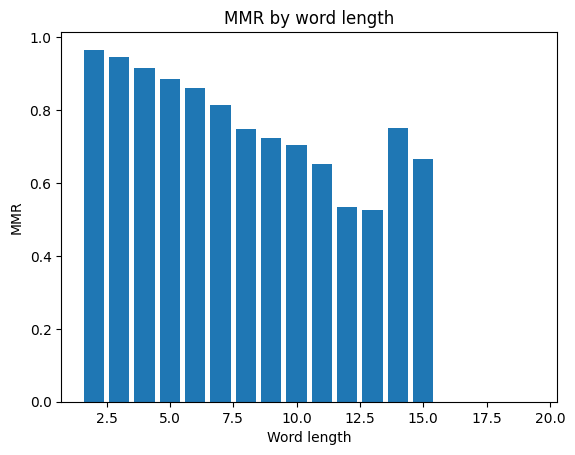

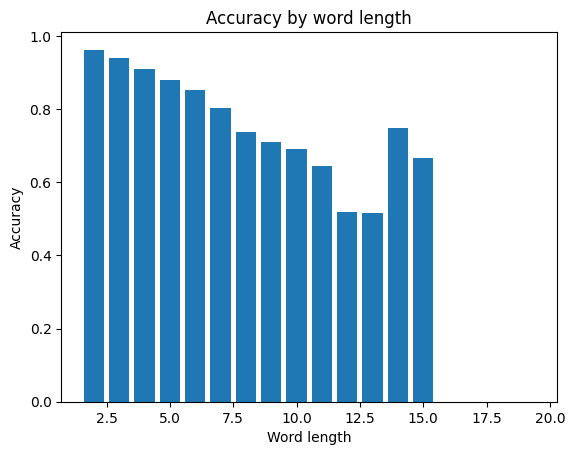

In [24]:
import matplotlib.pyplot as plt

plt.bar(word_len_to_mmr.keys(), word_len_to_mmr.values())
plt.xlabel('Word length')
plt.ylabel('MMR')
plt.title('MMR by word length')
plt.show()

plt.bar(word_len_to_accuracy.keys(), word_len_to_accuracy.values())
plt.xlabel('Word length')
plt.ylabel('Accuracy')
plt.title('Accuracy by word length')
plt.show()

In [31]:
errors_accuracy = []

for pred, label in zip(single_preds, val_labels):
    if pred != label:
        errors_accuracy.append((pred, label))

In [32]:
errors_mmr = []

for pred, label in zip(preds_only_cut_to_four, val_labels):
    if label not in pred:
        errors_mmr.append((pred, label))

In [33]:
len(errors_accuracy), len(errors_mmr)

(1148, 522)

In [38]:
print(*errors_mmr[:20], sep = '\n')

(['бычатся', 'баса', 'бычье', 'бычачий'], 'была')
(['самого', 'самое', 'самегрело', 'само'], 'свинг')
(['шавкат', 'шавками', 'шавка', 'шавката'], 'шакалов')
(['запихала', 'запахал', 'запахало', 'запахла'], 'замазала')
(['уроков', 'уровень', 'убрано', 'уровне'], 'корень')
(['вызвала', 'вызывала', 'выздоравливал', 'выздоравливай'], 'вызовов')
(['побрал', 'проблем', 'побрать', 'побрил'], 'пробовал')
(['русским', 'русском', 'русских', 'русский'], 'русскому')
(['мазда', 'мазде', 'мазды', 'мазов'], 'мазок')
(['звони', 'звание', 'звания', 'знаем'], 'зачем')
(['обед', 'обод', 'объезд', 'обода'], 'обувь')
(['дон', 'боре', 'доре', 'лоре'], 'он')
(['кедам', 'кеда', 'кедах', 'езжай'], 'уезжай')
(['аркин', 'апекса', 'апексе', 'апекс'], 'агапкина')
(['забери', 'забрать', 'забьет', 'заберите'], 'заберем')
(['звоню', 'знаю', 'знаешь', 'звони'], 'завтра')
(['окей-окей', 'лезут', 'около', 'окошко'], 'ощущение')
(['росу', 'романчик', 'романыч', 'росен'], 'романович')
(['работать', 'работаю', 'работал', '

In [39]:
word_len_to_labels = {word_len: [label for i, label in enumerate(val_labels) if i in idxs]
                        for word_len, idxs in word_len_to_idxs.items()}

In [41]:
word_len_to_labels.keys()

dict_keys([2, 3, 6, 7, 5, 4, 8, 10, 9, 13, 12, 11, 17, 14, 15, 19])

In [42]:
word_len_to_labels[19]

['сверхъестественного']

# Feats comparison (Visualization of evaluation.py results)


In [232]:
ORANGE = '#FFB60A'
RED = '#CE123E'
GREEN = '#05B384'
BLACK = '#000000'
BLUE = '#008EE0'
PURPLE = '#5B4587'

In [233]:
from typing import Optional
import os
import pandas as pd


df = pd.read_csv('../results/evaluation_results_v3.csv')

df['epoch'] = df['model_weights'].apply(lambda x: int(x.split('epoch=')[1].split('-')[0]))


def get_feats_type(weights_path: str) -> Optional[str]:
    feats_types = ['my_features_1', 'phrase_swipe_features', 
                   'my_weighted_features', 'my_nearest_features',
                   'indiswipe_features', 'google_2015_features',
                   'trainable_gaussian_weights_and_traj_transformer_bigger,']
    for feats_type in feats_types:
        if feats_type in weights_path:
            return feats_type
    return None

df['feats_type'] = df['model_weights'].apply(get_feats_type)
df['feats_type'] = df['feats_type'].fillna(df['model_name'])

m_name_allais_dict = {
    # 'my_weighted_features': 'my_features_weighted',
    # 'transformer_m1_bigger': 'my_features_nearest_old_run',
    # 'my_nearest_features': 'my_features_nearest',
    # 'phrase_swipe_features': 'phrase_swipe_features',
    'trainable_gaussian_weights_and_traj_transformer_bigger': 'my_trainable_gaussian_weights'
}

df['feats_type'] = df['feats_type'].apply(lambda x: m_name_allais_dict.get(x, x))


df.sort_values(by="epoch", ascending=True, inplace=True)

df[['epoch', 'model_name', 'feats_type', 'mmr', 'accuracy']]

,epoch,model_name,feats_type,mmr,accuracy
27,0,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.823866,0.815739
198,0,v3_nearest_and_traj_transformer_bigger,google_2015_features,0.792315,0.783135
343,0,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.811785,0.803632
161,0,v3_nearest_and_traj_transformer_bigger,my_nearest_features,0.816233,0.808093
283,0,v3_nearest_only_transformer_bigger,phrase_swipe_features,0.801554,0.792799
...,...,...,...,...,...
10,91,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889578,0.883602
97,92,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889077,0.883071
78,93,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.886237,0.879779
83,94,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889777,0.883815


In [234]:
incorrect_weighted_feats__weights = [
    'weighted_transformer_bigger-default--epoch=25-val_loss=0.44-val_word_level_accuracy=0.87.pt',
    'weighted_transformer_bigger-default--epoch=26-val_loss=0.44-val_word_level_accuracy=0.87.pt'
]


for weights_name in incorrect_weighted_feats__weights:
    i = df[((df.feats_type == 'my_features_weighted') & df.model_weights.apply(lambda x: weights_name in x))].index
    df = df.drop(i)


In [235]:
df.model_weights.apply(lambda x: x.endswith(weights_name)) 

27     False
198    False
343    False
161    False
283    False
       ...  
10     False
97     False
78     False
83     False
51     False
Name: model_weights, Length: 364, dtype: bool

In [236]:
df

,model_name,model_weights,generator_name,generator_call_kwargs,use_vocab_for_generation,grid_name,dataset_split,include_coords,include_time,include_velocities,include_accelerations,transform_name,mmr,accuracy,epoch,feats_type
27,v3_weighted_and_traj_transformer_bigger,./results/models_for_debug/my_weighted_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_distance_weights,0.823866,0.815739,0,my_weighted_features
198,v3_nearest_and_traj_transformer_bigger,./results/models_for_debug/google_2015_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,True,False,False,traj_feats_and_nearest_key,0.792315,0.783135,0,google_2015_features
343,v3_nearest_and_traj_transformer_bigger,./results/models_for_debug/indiswipe_features/...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,False,traj_feats_and_nearest_key,0.811785,0.803632,0,indiswipe_features
161,v3_nearest_and_traj_transformer_bigger,./results/models_for_debug/my_nearest_features...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_nearest_key,0.816233,0.808093,0,my_nearest_features
283,v3_nearest_only_transformer_bigger,./results/models_for_debug/phrase_swipe_featur...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,False,False,False,False,nearest_key_only,0.801554,0.792799,0,phrase_swipe_features
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,v3_weighted_and_traj_transformer_bigger,./results/models_for_debug/my_weighted_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_distance_weights,0.889578,0.883602,91,my_weighted_features
97,v3_weighted_and_traj_transformer_bigger,./results/models_for_debug/my_weighted_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_distance_weights,0.889077,0.883071,92,my_weighted_features
78,v3_weighted_and_traj_transformer_bigger,./results/models_for_debug/my_weighted_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_distance_weights,0.886237,0.879779,93,my_weighted_features
83,v3_weighted_and_traj_transformer_bigger,./results/models_for_debug/my_weighted_feature...,beam,"{""max_steps_n"": 35, ""return_hypotheses_n"": nul...",True,default,val,True,False,True,True,traj_feats_and_distance_weights,0.889777,0.883815,94,my_weighted_features


In [237]:
sorted_epoches = sorted(df[df['feats_type'] == 'my_features_weighted']['epoch'])
for i, e in enumerate(sorted_epoches):
    if i != e:
        print(i, e)

In [238]:
df = df.drop_duplicates()

17	7	v2_weighted_transformer_bigger	my_features_weighted	0.872353	0.865336
99	7	v2_weighted_transformer_bigger	my_features_weighted	0.872353	0.865336
80	14	v2_weighted_transformer_bigger	my_features_weighted	0.883763	0.877443
15	14	v2_weighted_transformer_bigger	my_features_weighted	0.883763	0.877443
81	20	v2_weighted_transformer_bigger	my_features_weighted	0.885807	0.879354
16	20	v2_weighted_transformer_bigger	my_features_weighted	0.885807	0.879354
82	26	v2_weighted_transformer_bigger	my_features_weighted	0.885746	0.879460
4	26	v2_weighted_transformer_bigger	my_features_weighted	0.885746	0.879460
83	30	v2_weighted_transformer_bigger	my_features_weighted	0.884446	0.878080
5	30	v2_weighted_transformer_bigger	my_features_weighted	0.884446	0.878080
84	33	v2_weighted_transformer_bigger	my_features_weighted	0.886884	0.880735
85	34	v2_weighted_transformer_bigger	my_features_weighted	0.889239	0.883284
6	34	v2_weighted_transformer_bigger	my_features_weighted	0.889239	0.883284
86	35	v2_weighted_transformer_bigger	my_features_weighted	0.887332	0.881054
87	36	v2_weighted_transformer_bigger	my_features_weighted	0.885333	0.878929
88	37	v2_weighted_transformer_bigger	my_features_weighted	0.884716	0.878292
7	38	v2_weighted_transformer_bigger	my_features_weighted	0.888645	0.882647
89	38	v2_weighted_transformer_bigger	my_features_weighted	0.888645	0.882647
90	39	v2_weighted_transformer_bigger	my_features_weighted	0.888778	0.882753
91	40	v2_weighted_transformer_bigger	my_features_weighted	0.889284	0.883178
92	41	v2_weighted_transformer_bigger	my_features_weighted	0.887466	0.881372
93	42	v2_weighted_transformer_bigger	my_features_weighted	0.886970	0.880947
94	43	v2_weighted_transformer_bigger	my_features_weighted	0.889790	0.883709
95	44	v2_weighted_transformer_bigger	my_features_weighted	0.889814	0.883815
96	46	v2_weighted_transformer_bigger	my_features_weighted	0.888254	0.882222
8	46	v2_weighted_transformer_bigger	my_features_weighted	0.888254	0.882222
97	55	v2_weighted_transformer_bigger	my_features_weighted	0.889191	0.883071
9	55	v2_weighted_transformer_bigger	my_features_weighted	0.889191	0.883071
98	60	v2_weighted_transformer_bigger	my_features_weighted	0.889399	0.883496
10	60	v2_weighted_transformer_bigger	my_features_weighted	0.889399	0.883496

In [239]:
df[['epoch', 'model_name', 'feats_type', 'mmr', 'accuracy']][df['mmr'] > 0.89]

,epoch,model_name,feats_type,mmr,accuracy
21,45,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890269,0.884452
9,48,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890477,0.884558
57,54,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890695,0.884771
61,58,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.891508,0.885514
44,62,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890164,0.884133
88,63,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890707,0.884771
76,66,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890315,0.884346
43,69,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890016,0.884240
24,80,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.890104,0.884133
36,81,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.891142,0.885089


In [240]:
df[['epoch', 'model_name', 'feats_type', 'mmr', 'accuracy']][df['feats_type'] == 'indiswipe_features']

,epoch,model_name,feats_type,mmr,accuracy
343,0,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.811785,0.803632
336,1,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.834021,0.826147
324,2,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.848049,0.840803
360,3,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.853218,0.846007
320,4,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.858580,0.851317
...,...,...,...,...,...
350,63,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.882356,0.875956
321,64,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.883582,0.877230
303,65,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.882712,0.876381
302,66,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.884690,0.878611


In [241]:
df[['epoch', 'model_name', 'feats_type', 'mmr', 'accuracy']][df['feats_type'] == 'my_trainable_gaussian_weights']

,epoch,model_name,feats_type,mmr,accuracy


In [242]:
{int(i) for i in df[['epoch']][df['feats_type'] == 'my_trainable_gaussian_weights'].values}

#{4, 8, 9, 10, 13, 15, 16, 17, 19, 23, 26, 27, 28}

set()

In [243]:
df[['epoch', 'model_name', 'feats_type', 'mmr', 'accuracy']]

,epoch,model_name,feats_type,mmr,accuracy
27,0,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.823866,0.815739
198,0,v3_nearest_and_traj_transformer_bigger,google_2015_features,0.792315,0.783135
343,0,v3_nearest_and_traj_transformer_bigger,indiswipe_features,0.811785,0.803632
161,0,v3_nearest_and_traj_transformer_bigger,my_nearest_features,0.816233,0.808093
283,0,v3_nearest_only_transformer_bigger,phrase_swipe_features,0.801554,0.792799
...,...,...,...,...,...
10,91,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889578,0.883602
97,92,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889077,0.883071
78,93,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.886237,0.879779
83,94,v3_weighted_and_traj_transformer_bigger,my_weighted_features,0.889777,0.883815


In [244]:
# i = df[((df.feats_type == 'indiswipe_features') &( df.epoch == 29))].index
# df = df.drop(i)


# my_weighted_drop_epoches = [35, 36, 37, 39, 40, 41, 42, 45]

# for epoch_i in my_weighted_drop_epoches:
#     i = df[((df.feats_type == 'my_features_weighted') &( df.epoch == epoch_i))].index
#     df = df.drop(i)


# my_gaussian_drop_epoches = list(range(4))

# for epoch_i in my_gaussian_drop_epoches:
#     i = df[((df.feats_type == 'my_trainable_gaussian_weights') &( df.epoch == epoch_i))].index
#     df = df.drop(i)

In [245]:
df.feats_type.unique()

array(['my_weighted_features', 'google_2015_features',
       'indiswipe_features', 'my_nearest_features',
       'phrase_swipe_features'], dtype=object)

In [246]:
report_feat_names_dict = {
    'google_2015_features': 'Google_2015_features',
    'indiswipe_features': 'Indiswipe_features',
    'my_features_nearest_old_run': 'My_features_nearest (старый запуск)',
    'my_weighted_features': 'My_features_weighted (НАШ)',
    'phrase_swipe_features': 'Phrase_swipe_features',
    'my_nearest_features': 'my_features_nearest (НАШ)',
    'my_trainable_gaussian_weights': 'My_trainable_gaussian_weights (НАШ)'
}

df['report_feat_names'] = df['feats_type'].apply(lambda x: report_feat_names_dict[x])

In [247]:
# наименьшее число эпох обучения среди представленных моделей
report_name_to_n_epoches = df.groupby("report_feat_names").max()['epoch']
min_epoches_among_all = min(report_name_to_n_epoches)  
min_epoches_among_all

57

In [248]:
report_name_to_n_epoches

report_feat_names
Google_2015_features          57
Indiswipe_features            67
My_features_weighted (НАШ)    95
Phrase_swipe_features         64
my_features_nearest (НАШ)     74
Name: epoch, dtype: int64

In [249]:
min_epoch = 0
# max_epoch = min_epoches_among_all
max_epoch = 100


feats_to_show = ['mmr', 'accuracy']  # ['mmr', 'accuracy']
comparison_table = df[(df['epoch'] >= min_epoch) & (df['epoch'] <= max_epoch)].groupby("report_feat_names").max()[feats_to_show].sort_values(by=['mmr', 'accuracy'], ascending=False)
comparison_table

metric_names = ['mmr', 'accuracy']

for metric in metric_names:
    epoches = []
    for row_id, row in comparison_table.iterrows():
        df_row = df[(df['report_feat_names'] == row_id) & (df[metric] == row[metric])]
        epoches.append(int(df_row['epoch'].iloc[0]))
    comparison_table[f"max_{metric}_epoch"] = epoches


for metric in metric_names:
    comparison_table[metric] = comparison_table[metric].apply(lambda x: round(x, 4))

comparison_table

,mmr,accuracy,max_mmr_epoch,max_accuracy_epoch
report_feat_names,,,,
My_features_weighted (НАШ),0.8922,0.8865,90,90
my_features_nearest (НАШ),0.8886,0.8826,73,73
Indiswipe_features,0.8863,0.8801,31,31
Google_2015_features,0.8804,0.8737,53,53
Phrase_swipe_features,0.8712,0.8645,55,55


In [250]:
def get_rows_sorted_by_epoch(df) -> list:
    rows = [row for idx, row in df.iterrows()]
    rows.sort(key = lambda row: row['epoch'])
    return rows

In [251]:
metric_names = ['mmr', 'accuracy']

# model_name_to_metrics is a Dict that maps model_name to metrics
# metrics is a Dict that maps metric name to a Tuple of two Lists:
# 1. metric values
# 2. corresponding epoch numbers
feats_type_to_metrics = {
    feats_type: {metric_name: ([], []) for metric_name in metric_names}
    for feats_type in df['feats_type'].unique()
}

rows = get_rows_sorted_by_epoch(df)


for row in rows:
    epoches, accuracies = feats_type_to_metrics[row['feats_type']]['accuracy']
    epoches.append(row['epoch'])
    accuracies.append(row['accuracy'])

    epoches, mmrs = feats_type_to_metrics[row['feats_type']]['mmr']
    epoches.append(row['epoch'])
    mmrs.append(row['mmr'])

In [252]:
# feats_type_to_metrics

In [253]:
# import matplotlib.pyplot as plt

# for metric_name in metric_names:
#     for model_name, metrics in model_name_to_metrics.items():
#         epoches, values = metrics[metric_name]
#         plt.plot(epoches, values, label=model_name)
#     plt.title(f'beam search: {metric_name} vs epoch')
#     plt.xlabel('epoch')
#     plt.ylabel(metric_name)
#     plt.legend()
#     plt.show()

In [254]:
def cut_feats_to_metrics(feats_type_to_metrics, min_epoch, max_epoch):


    metric_names = list(list(feats_type_to_metrics.values())[0].keys())  # ['mmr', 'accuracy']
    feats_types = list(feats_type_to_metrics.keys())

    feats_type_to_metrics_copy = {
        feats_type: {metric_name: ([], []) for metric_name in metric_names}
        for feats_type in feats_types
    }

    for model_name, metrics in feats_type_to_metrics.items():
        for metric_name, epoches_and_values in metrics.items():
            epoches, values = epoches_and_values
            min_i = None
            max_i = None


            for i, epoch in enumerate(epoches):
                if epoch >= min_epoch:
                    min_i = i
                    break
            
            for i, epoch in reversed(list(enumerate(epoches))):
                if epoch <= max_epoch:
                    max_i = i
                    break
            
            feats_type_to_metrics_copy[model_name][metric_name] = (epoches[min_i:max_i+1], values[min_i:max_i+1])
    
    return feats_type_to_metrics_copy
            
            


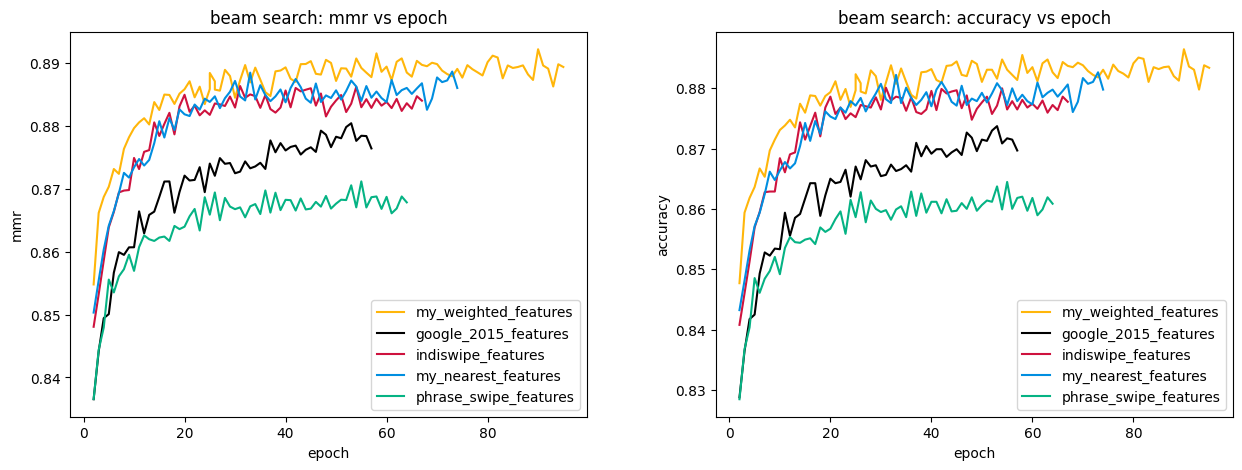

In [255]:
import matplotlib.pyplot as plt

MIN_EPOCH = 2
MAX_EPOCH = 1000

feats_type_to_metrics_cut = cut_feats_to_metrics(feats_type_to_metrics, MIN_EPOCH, MAX_EPOCH)

feats_type_to_color = {
    'my_weighted_features': ORANGE,
    'my_features_nearest_old_run': 'yellow',
    'phrase_swipe_features': GREEN,
    'my_nearest_features': BLUE,
    'google_2015_features': BLACK,
    'indiswipe_features': RED,
    'my_trainable_gaussian_weights': PURPLE
}

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

for i, metric_name in enumerate(metric_names):
    ax = axes[i]  # Select the subplot
    for feats_type, metrics in feats_type_to_metrics_cut.items():
        epoches, values = metrics[metric_name]

        # assert epoches == list(range(len(epoches)))
        assert epoches == sorted(epoches)

        color = feats_type_to_color[feats_type]

        if feats_type == 'my_trainable_gaussian_weights':
            continue

        
        ax.plot(epoches, values, label=feats_type, color=color)
    ax.set_title(f'beam search: {metric_name} vs epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric_name)
    ax.legend()

plt.subplots_adjust(wspace=0.25) 
plt.show()

# Tensorboard visualization

In [532]:
import os
import matplotlib.pyplot as plt
from typing import Dict


import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [75]:
from typing import Dict

import pandas as pd
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from tqdm import tqdm


def tb_dir_to_pd_dict(log_dir: str) -> Dict[str, Dict[str, pd.DataFrame]]:
    # Dictionary to hold tag dataframes
    tag_data = {}
    
    # Load event accumulator
    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()
    
    # Extract tags
    tags = event_acc.Tags()['scalars']
    
    for tag in tags:
        # Get scalar events
        events = event_acc.Scalars(tag)
        # Extract data
        steps = [e.step for e in events]
        wall_times = [e.wall_time for e in events]
        values = [e.value for e in events]
        # Create dataframe
        tag_data[tag] = pd.DataFrame({'step': steps, 'wall_time': wall_times, 'value': values})
    
    return tag_data



def remove_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

def remove_outliners_for_all_metrics(metrics):
    return {metric_name: remove_outliers(metric_df, 'value')
            for metric_name, metric_df in metrics.items()}

def remove_outliers_for_all_models(model_to_metrics):
    return {
        model_name: remove_outliners_for_all_metrics(metrics)
        for model_name, metrics in model_to_metrics.items()
    }



def remove_steps_lower(df: pd.DataFrame, lower_limit: str) -> pd.DataFrame:
    return df[(df['step'] >= lower_limit)]

def remove_steps_lower_all_metrics(metrics, lower):
    return {metric_name: remove_steps_lower(metric_df, lower)
            for metric_name, metric_df in metrics.items()}

def remove_steps_lower_for_all_models(model_to_metrics, lower):
    return {
        model_name: remove_steps_lower_all_metrics(metrics, lower)
        for model_name, metrics in model_to_metrics.items()
    }




def get_model_name_to_metrics__from_tb(log_dirs: Dict[str, str]) -> Dict[str, Dict[str, Dict[str, pd.DataFrame]]]:
    return {model_name: tb_dir_to_pd_dict(dir) for model_name, dir in tqdm(log_dirs.items())}


In [76]:
log_dirs = r"F:\yandex_cup_neuroswipe_all\tb_logs\feats_comparison\tg_with_centers_2"

In [77]:
tb_path = r'F:\yandex_cup_neuroswipe_all\tb_logs\feats_comparison\feats_comparison'

log_dirs = {
    'google_2015_feats': os.path.join(tb_path, 'google_2015_feats'),
    'indiswipe_feats': os.path.join(tb_path, 'indiswipe_feats'),
    'my_nearest_feats': os.path.join(tb_path, 'my_nearest_feats'),
    'my_weighted_feats': os.path.join(tb_path, 'my_weighted_feats'),
    'phraseswipe_feats': os.path.join(tb_path, 'phraseswipe_feats'),
    'trainable_normal_feats': os.path.join(tb_path, '..', 'tg_with_centers_2'),
}

In [78]:
model_to_metrics = get_model_name_to_metrics__from_tb(log_dirs)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:47<03:56, 47.23s/it]

KeyboardInterrupt: 

In [79]:
# model_to_metrics = remove_outliers_for_all_models(model_to_metrics)
model_to_metrics_2 = remove_steps_lower_for_all_models(model_to_metrics, 25000)

In [80]:
model_names = list(model_to_metrics.keys())
metric_names = list(model_to_metrics[model_names[0]].keys())

print(f"{model_names = }")
print(f"{metric_names = }")

model_names = ['google_2015_feats', 'indiswipe_feats', 'my_nearest_feats', 'my_weighted_feats', 'phraseswipe_feats', 'trainable_normal_feats']
metric_names = ['train_token_level_accuracy', 'train_token_level_f1', 'train_word_level_accuracy_step', 'train_loss_step', 'epoch', 'val_token_level_accuracy', 'val_token_level_f1', 'val_word_level_accuracy', 'val_loss', 'train_word_level_accuracy_epoch', 'train_loss_epoch']


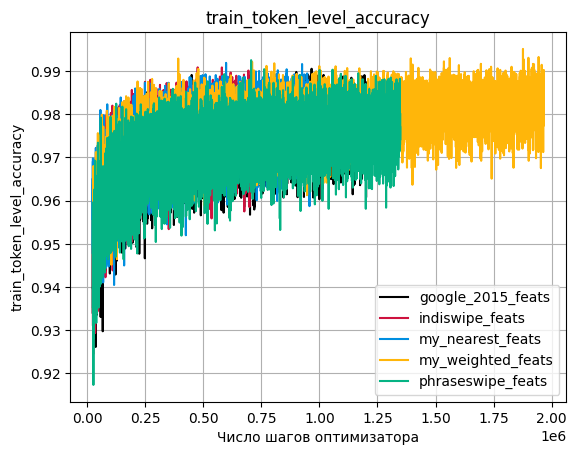

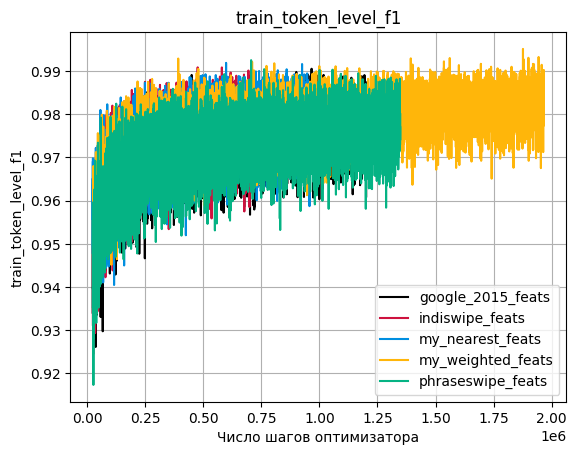

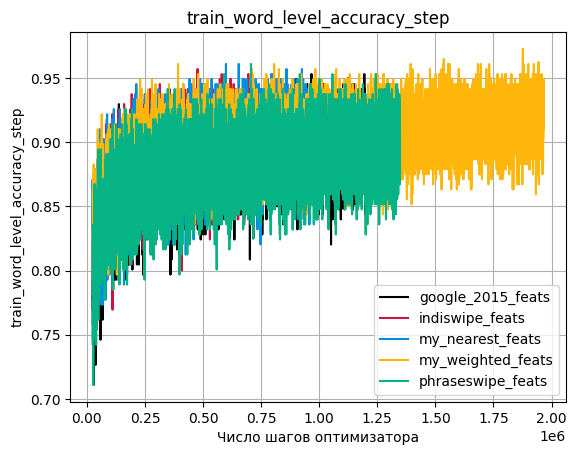

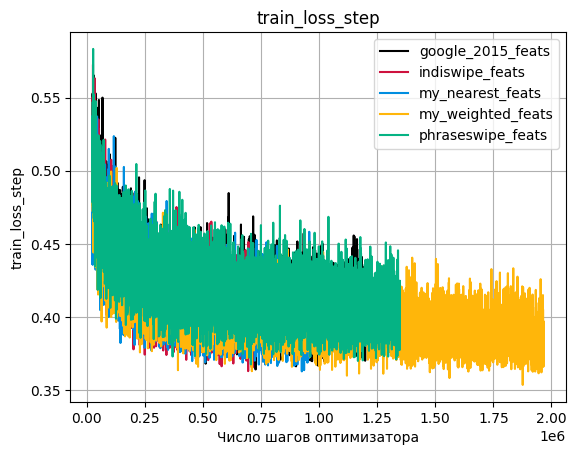

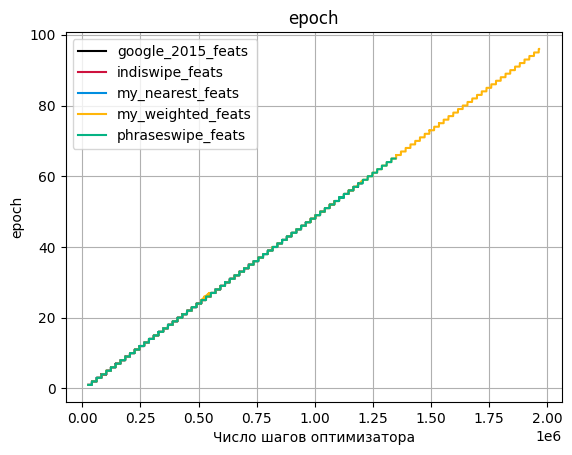

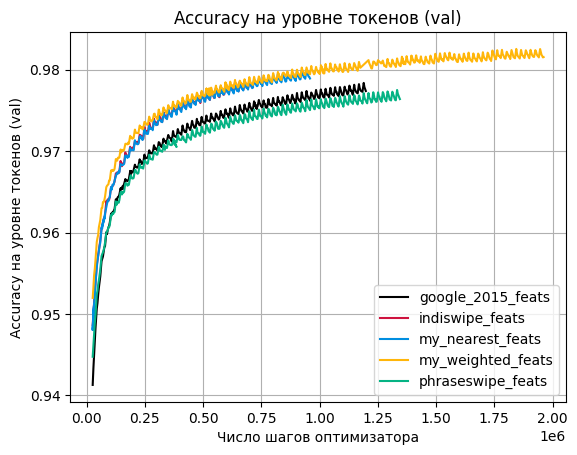

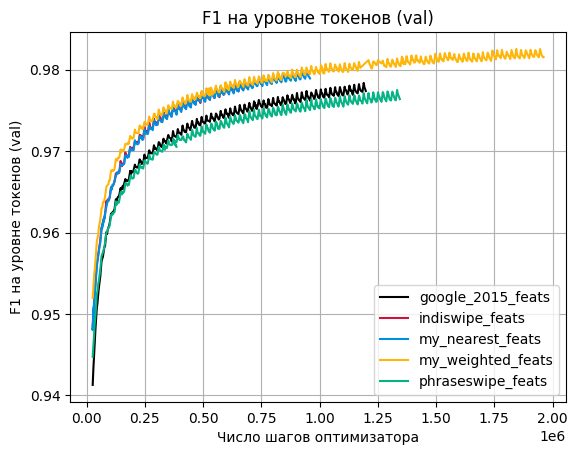

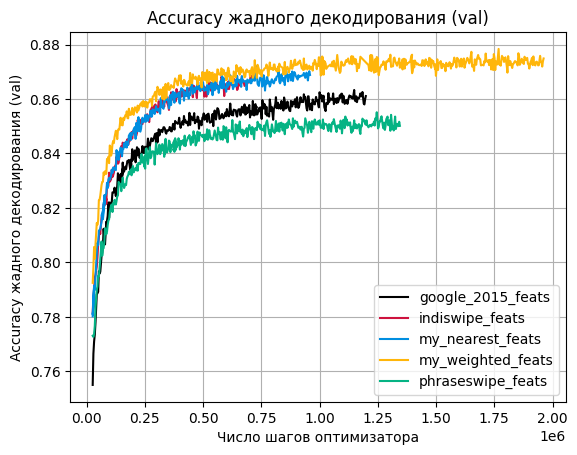

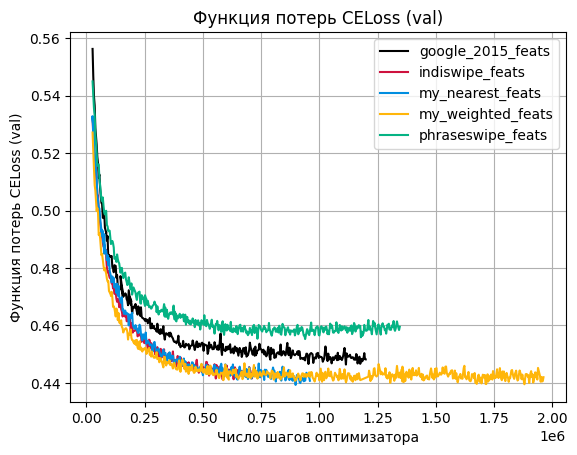

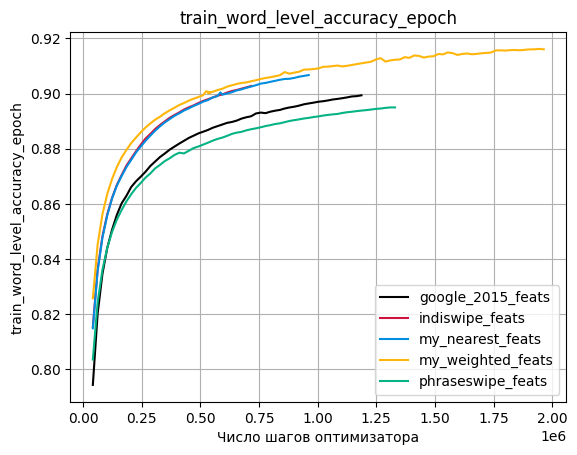

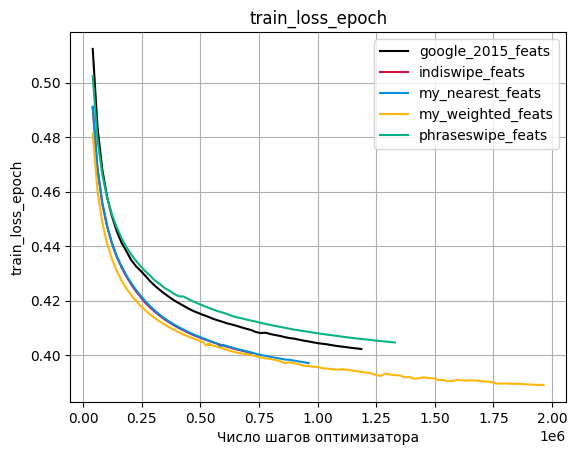

In [81]:
import matplotlib.pyplot as plt


feats_type_to_color = {
    'my_weighted_feats': ORANGE,
    'my_nearest_feats': BLUE,
    'phraseswipe_feats': GREEN,
    'google_2015_feats': BLACK,
    'indiswipe_feats': RED,
    'trainable_normal_feats': PURPLE,
}

metric_name_dict = {
    'val_word_level_accuracy': 'Accuracy жадного декодирования (val)',
    'val_loss': 'Функция потерь CELoss (val)',
    'val_token_level_f1': 'F1 на уровне токенов (val)',
    'val_token_level_accuracy': 'Accuracy на уровне токенов (val)',
}

for metric_name in metric_names:
    for model_name, metrics in model_to_metrics_2.items():
        if model_name == 'trainable_normal_feats':
            continue
        metric = metrics[metric_name]
        epoches, values = metric['step'], metric['value']
        color = feats_type_to_color[model_name]
        plt.plot(epoches, values, label=model_name, color=color)
    m_name_converted = metric_name_dict.get(metric_name, metric_name)
    plt.title(m_name_converted)
    plt.xlabel('Число шагов оптимизатора')
    plt.ylabel(m_name_converted)
    plt.legend()
    plt.grid(True)
    plt.show()

# Weights function

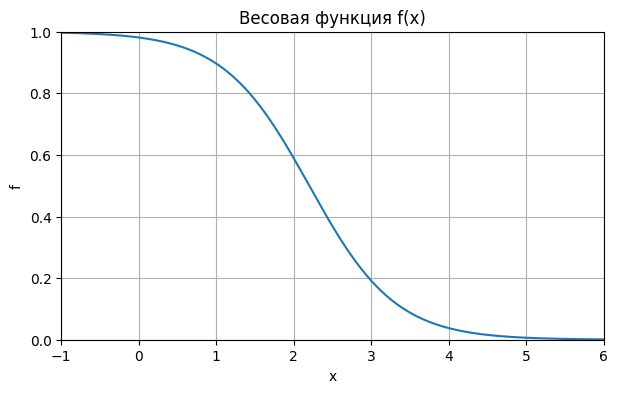

In [415]:
import matplotlib.pyplot as plt
import numpy as np

def weights_func(x: float) -> float:
    return 1/(1+np.exp(1.8*(x-2.2)))

# Data for plotting
x = np.arange(-1.0, 6.0, 0.01)
values = [weights_func(x_i) for x_i in x]

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, values)
ax.set_xlim(-1, 6)
ax.set_ylim(0, 1)

ax.set(xlabel='x', ylabel='f',
       title='Весовая функция f(x)')
ax.grid()

fig.savefig("test.png")
plt.show()

# weighted method vizualization

In [302]:
%load_ext autoreload
%autoreload 2

In [303]:
from keyboard_start.tools.viz import plot_keyboard
from grid_processing_utils import get_grid, get_wh

In [304]:
def find_key_by_letter(grid, letter):
    keys = grid['keys']
    for key in keys:
        if 'label' not in key:
            continue
        if key.get('label') == letter:
            return key

def get_kb_key_center(key):
    h = key.get('background', key.get('hitbox'))
    x, y, w, h = h['x'], h['y'], h['w'], h['h']
    return x + w/2, y + h/2

In [305]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import FancyBboxPatch
from matplotlib.collections import PatchCollection, LineCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D


def _get_whk(event):
    grid = event  # old version
    if 'curve' in event and 'grid' in event['curve']:
        grid = event['curve']['grid']
    return grid['width'], grid['height'], grid['keys']


def plot_keyboard_3d(event, word=''):
    width, height, keys = _get_whk(event)

    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlim([0, width])
    ax.set_ylim([0, height])
    ax.set_zlim([0, 10])  # Set a default z-axis limit

    fig.subplots_adjust(
        top=0.86,
        bottom=0.09,
        left=0.100,
        right=0.925,
        hspace=0.2,
        wspace=0.2
    )

    for key in keys:
        h = key.get('background', key.get('hitbox'))
        x, y, w, h = h['x'], h['y'], h['w'], h['h']
        z = 0  # All keys lie on the z=0 plane

        # Define the 3D rectangle (a cuboid) for each key
        vertices = [
            [x, y, z],
            [x + w, y, z],
            [x + w, y + h, z],
            [x, y + h, z],
            [x, y, z],
        ]
        faces = [[vertices[j] for j in [0, 1, 2, 3]]]

        poly = Poly3DCollection(faces, alpha=.25, facecolors='powderblue', edgecolors='black')
        ax.add_collection3d(poly)

        if key.get('label') and key['label'] in word:
            poly.set_facecolor('yellow')
        
        ch = key.get('label', '@')
        ch = ch if (ch and (ch.isalnum() or ch.isascii())) else '@'
        ax.text(x + w / 2, y + h / 2, z, ch, color='black', fontsize=10, ha='center', va='center')

    return fig, ax


In [306]:
# BIAS = 1.8
# SCALE = 2.8

BIAS = 2.2
SCALE = 1.8

In [307]:
def weights_func_3d_v1(x, y, key_x, key_y, key_half_diag, bias, scale) -> float:
    d = np.sqrt((x - key_x) ** 2 + (y - key_y) ** 2)
    return 1/(1+np.exp(scale * (d/key_half_diag - bias)))

def plot_weights_3d(key_x: int, key_y: int, weights_func_3d, width, height, key_half_diag, fig, ax, bias, scale
                    ) -> None:
    x = np.linspace(0, width, width)
    y = np.linspace(0, height, height)
    X, Y = np.meshgrid(x, y)
    Z = weights_func_3d(X, Y, key_x, key_y, key_half_diag, bias, scale)

    
    # light cmap only edges
    ax.plot_surface(X, Y, Z, 
                    cmap='Oranges', 
                    edgecolor='gray', 
                    alpha=0.2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

In [ ]:
grid = get_grid('default', '../data/data_separated_grid/gridname_to_grid.json')



width, height = get_wh(grid)

fig, ax = plot_keyboard(grid, word = 'р')
ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plt.show()

In [ ]:
grid = get_grid('default', '../data/data_separated_grid/gridname_to_grid.json')



width, height = get_wh(grid)

letter = 'р'

fig, ax = plot_keyboard_3d(grid, word = letter)



ax.set_xlim([0, width])
ax.set_ylim([height, 0])

ax.view_init(elev=20, azim=310)

plt.show()

In [310]:
# %matplotlib widget 


In [ ]:
grid = get_grid('default', '../data/data_separated_grid/gridname_to_grid.json')



width, height = get_wh(grid)

letter = 'р'

letter = 'р'
key = find_key_by_letter(grid, letter)
key_x, key_y = get_kb_key_center(key)
key_half_diag = np.sqrt(key['hitbox']['w']**2 + key['hitbox']['h']**2)/2

fig, ax = plot_keyboard_3d(grid, word = letter)

ax.set_xlim([0, width])
ax.set_ylim([height, 0])

plot_weights_3d(key_x, key_y, weights_func_3d_v1, width, height, key_half_diag, fig, ax, BIAS, SCALE)

ax.set_xlim([0, width])
ax.set_ylim([height, 0])
ax.set_zlim([0, 1])

# adjust angle
ax.view_init(elev=20, azim=310)

plt.show()

In [312]:
# import base64
# import json
# import matplotlib.pyplot as plt
# import numpy as np
# import os
# import sys

# from argparse import ArgumentParser
# from gzip import GzipFile
# from io import BytesIO
# from matplotlib.patches import FancyBboxPatch
# from matplotlib.collections import PatchCollection, LineCollection


# def normalize(s):
#     return s.lower().replace('ё', 'е')


# def drop_punctuation(s):
#     return s.replace('-', '').replace("'", "")


# def read_swipe_events(path, limit = -1):
#     with open(path, encoding="utf-8") as f:
#         for i, line in enumerate(f):
#             if i == limit:
#                 return

#             ps = line.rstrip('\n').split('\t')
#             curve = ps[0]
#             word = "" if len(ps) == 1 else ps[1]
#             try:
#                 content = base64.b64decode(curve)
#                 curve = GzipFile(fileobj=BytesIO(content), mode='rb').read()
#             except Exception:
#                 pass
#             j = json.loads(curve)
#             word = word or j.get('word')
#             yield (j, word)


# def _get_whk(event):
#     grid = event  # old version
#     if 'curve' in event and 'grid' in event['curve']:
#         grid = event['curve']['grid']
#     return grid['width'], grid['height'], grid['keys']


# def plot_keyboard(event, word=''):
#     width, height, keys = _get_whk(event)

#     fig = plt.figure(figsize=(30, 15))
#     ax = fig.add_subplot(111)

#     ax.set_xlim([0, width])
#     ax.set_ylim([0, height])

#     fig.subplots_adjust(
#         top=0.86,
#         bottom=0.09,
#         left=0.100,
#         right=0.925,
#         hspace=0.2,
#         wspace=0.2
#     )

#     patches = []
#     pressed_patches = []

#     for key in keys:
#         h = key.get('background', key.get('hitbox'))
#         p = FancyBboxPatch(
#             (h['x'], h['y']),
#              h['w'], h['h'],
#             boxstyle="round,pad=1",
#             fc='powderblue',
#             ec='black', zorder=1
#         )

#         if key.get('label') and key['label'] in word:
#             pressed_patches.append(p)
#         else:
#             patches.append(p)
#         ch = key.get('label', '@')
#         ch = ch if (ch and (ch.isalnum() or ch.isascii())) else '@'
#         ax.text(h['x'] + 10, h['y'] + h['h'] - 10, ch, fontsize=20)

#     collection = PatchCollection(patches)
#     collection.set_facecolor("powderblue")
#     collection.set_edgecolor("black")
#     ax.add_collection(collection)

#     pressed_collection = PatchCollection(pressed_patches)
#     pressed_collection.set_facecolor("bisque")
#     pressed_collection.set_edgecolor("black")
#     ax.add_collection(pressed_collection)
#     return fig, ax


# def plot_swipe(event, ref, plot_ideal_curve=False, plot_speed=False, draw_only_reference=False):
#     def get_key_center(key):
#         h = key.get('background', key.get('hitbox'))
#         return (h['x'] + h['w'] / 2, h['y'] + h['h'] / 2)

#     width, height, keys = _get_whk(event)
#     curve = event['curve']
#     if not ref:
#         ref = event.get('word', ref)

#     label2center = dict()
#     for key in keys:
#         if 'label' not in key:
#             continue
#         cx, cy = get_key_center(key)
#         label2center[key['label']] = (cx, cy)

#     if 'ё' not in label2center:
#         label2center['ё'] = label2center.get('е')

#     if 'ъ' not in label2center:
#         label2center['ъ'] = label2center.get('ь')

#     ref_lower = ref.lower()
#     ideal_curve_x = np.array([label2center[c][0] for c in ref_lower if c in label2center])
#     ideal_curve_y = np.array([label2center[c][1] for c in ref_lower if c in label2center])

#     # Plot keyboard.
#     #
#     fig, ax = plot_keyboard(event, ref_lower)

#     # Calculate velocity.
#     #
#     x = np.array(curve['x'])
#     y = np.array(curve['y'])
#     t = np.array(curve['t'])

#     if not len(x):
#         print(f"Empty event, skip it. Word={ref}", file=sys.stderr)
#         return fig, ax

#     # Main drawing part.
#     #
#     if plot_ideal_curve:
#         ax.plot(ideal_curve_x, ideal_curve_y, linewidth=3, color='salmon')
#     if plot_speed:
#         dt = t[1:] - t[:-1] + 0.5
#         v = np.linalg.norm(np.array([x, y]).T[1:] - np.array([x, y]).T[:-1], axis=1) / dt
#         max_v = np.max(v)

#         lwidths = 1 + (v / max_v) ** 0.5 * 10
#         points = np.array([x, y]).T.reshape(-1, 1, 2)
#         segments = np.concatenate([points[:-1], points[1:]], axis=1)

#         lc = LineCollection(segments, linewidths=lwidths, color='steelblue', zorder=10)
#         ax.add_collection(lc)
#     else:
#         ax.plot(x, y, linewidth=3, color='steelblue')

#     # Show timings.
#     #
#     for i in range(len(x)):
#         ax.text(x[i], y[i], i, fontsize=10, zorder=10, color='black')

#     ax.plot(x[0], y[0], 'go', markersize=12)
#     ax.plot(x[-1], y[-1], 'ro', markersize=12)

#     ax.set_xlim([0, width])
#     ax.set_ylim([height, 0])

#     # Print suggestion information.
#     #
#     def sy(y):
#         return y / 1200 * height

#     if 'context' in event:
#         context = event['context']
#         show = event.get('show', -1)
#         oracle = event.get('oracle', False)
#         unk = event.get('unk', False)
#         ax.text(0, sy(-185), f'Context: "{context}" Reference: "{ref}" Time: {t[-1]}ms Show: {show} '
#                              f'Unk: {unk} Oracle: {oracle}', fontsize=20)

#     if 'result' in event:
#         result = event['result']

#         def draw_alignment(alignment, word, color, pos):
#             xa = alignment['x']
#             ya = alignment['y']
#             ax.scatter(xa, ya, color=color, s=150, zorder=20 - pos, alpha=0.75)
#             word = normalize(drop_punctuation(word))

#             for i in range(len(xa)):
#                 ax.text(xa[i], ya[i] - sy(10), word[i], fontsize=25, zorder=30 - pos, color=color)

#         COLORS = ('green', 'purple', 'red', 'gray', 'magenta', 'black')
#         for i, (word, values) in enumerate(result.items(), start=1):
#             alignment = values.pop('alignment', None)
#             color = 'brown' if draw_only_reference else COLORS[i - 1]

#             text = f'{i}: {word} {values}'
#             ax.text(0, sy(-180 + 25 * i), text, fontsize=16, color=color)

#             if not draw_only_reference and alignment:
#                 draw_alignment(alignment, word, color, i)

#             values['alignment'] = alignment
#             if i == len(COLORS):
#                 break

#         if draw_only_reference:
#             for i, (word, values) in enumerate(result.items(), start=1):
#                 if normalize(word) != normalize(ref):
#                     continue

#                 alignment = values.pop('alignment', None)
#                 text = f'{i}: {word} {values}'
#                 i = min(len(COLORS) + 1, i)
#                 color = 'magenta'

#                 ax.text(0, sy(-180 + 25 * i), text, fontsize=16, color=color)

#                 if alignment:
#                     draw_alignment(alignment, word, color, i)
#                     break

#     return fig, ax


# def main():
#     p = ArgumentParser()
#     p.add_argument('-p', '--path', help='path to swipe events', required=True)
#     p.add_argument('-o', '--output', help='output dict', default='curves')
#     p.add_argument('--overwrite', help='overwrite figures', action='store_true')
#     p.add_argument('--speed', help='use speed as width of lines', action='store_true')
#     p.add_argument('--ideal', help='draw ideal curve', action='store_true')
#     p.add_argument('-r', '--reference', help='draw only reference words', action='store_true')
#     p.add_argument('-l', '--limit', help='pictures to draw', type=int, default=-1)
#     args = p.parse_args()

#     events = read_swipe_events(args.path, args.limit)
#     os.makedirs(args.output, exist_ok=True)

#     for i, (event, ref) in enumerate(events, start=1):
#         name = f'{i:03d}'
#         if ref:
#             name = f'{name}_{ref}'
#         name += '.png'
#         save_path = os.path.join(args.output, name)
#         print(f'Processing "{save_path}"')

#         if os.path.exists(save_path) and not args.overwrite:
#             continue

#         fig, ax = plot_swipe(
#             event, ref=ref, plot_ideal_curve=args.ideal,
#             plot_speed=args.speed, draw_only_reference=args.reference
#         )
#         plt.savefig(save_path)
#         plt.close(fig)


# # if __name__ == '__main__':
# #     main()


# Params count start

# Get predict config model_params 

In [ ]:
import os

dir_path = "../results/models_for_debug/phrase_swipe_features"
gname = "default"
model_name = "v3_nearest_only_transformer_bigger"

for weights in os.listdir(dir_path):
    print(f'["{gname}", "{model_name}", "{weights}"]', end=',\n')

In [ ]:
import os

dir_path = "../results/models_for_debug/indiswipe_features"
gname = "default"
model_name = "v3_nearest_and_traj_transformer_bigger"

for weights in os.listdir(dir_path):
    print(f'["{gname}", "{model_name}", "{weights}"]', end=',\n')

In [ ]:
import os

dir_path = "../results/models_for_debug/google_2015_features"
gname = "default"
model_name = "v3_nearest_and_traj_transformer_bigger"

for weights in os.listdir(dir_path):
    print(f'["{gname}", "{model_name}", "{weights}"]', end=',\n')

In [ ]:
import os

dir_path = "../results/models_for_debug/my_weighted_features"
gname = "default"
model_name = "v3_weighted_and_traj_transformer_bigger"

for weights in os.listdir(dir_path):
    print(f'["{gname}", "{model_name}", "{weights}"]', end=',\n')

In [ ]:
import os

dir_path = "../results/models_for_debug/my_nearest_features"
gname = "default"
model_name = "v3_nearest_and_traj_transformer_bigger"

for weights in os.listdir(dir_path):
    print(f'["{gname}", "{model_name}", "{weights}"]', end=',\n')

# Temporary collate fn for trainable gaussian

In [ ]:
class CollateFnTemp:
    def __init__(self, char_tokenizer) -> None:
        self.collate_fn_orig = CollateFnV2(
            word_pad_idx = char_tokenizer.char_to_idx['<pad>'], batch_first = False)
    
    def __call__(self, batch: list):
        ((traj_feats, kb_feats), dec_in, encoder_pad_mask, word_pad_mask), dec_out = self.collate_fn_orig(batch) 
        # traj_feats.shape = seq_len, batch_size, n_feats
        coords = traj_feats[:, :, :2]
        return ((traj_feats, coords), dec_in, encoder_pad_mask, word_pad_mask), dec_out


# Move weighted_transformer_bigger to v3_weighted_and_traj_transformer_bigger

In [1]:
from model import MODEL_GETTERS_DICT

In [5]:
os.listdir()

['.ipynb_checkpoints',
 'aggregate_predictions.py',
 'ckpt_to_pt.py',
 'dataset.py',
 'dataset_transforms_comaprison',
 'data_analysis',
 'distances_lookup.py',
 'downloaders',
 'evaluate.py',
 'feature_extractors.py',
 'full_vocab_estimation.py',
 'get_probs_for_voc.py',
 'grid_processing_utils.py',
 'keyboard_start',
 'metrics.py',
 'model.py',
 'nearest_key_lookup.py',
 'ns_tokenizers.py',
 'playground.ipynb',
 'pl_module.py',
 'predict.py',
 'predictions_aggregation.ipynb',
 'predict_trainable_gaussian.py',
 'predict_v2.py',
 'separate_grid.py',
 'synthetic_data_generation',
 'tests__to_be_turned_to_unittests',
 'train.ipynb',
 'train_v2.ipynb',
 'train_v3.ipynb',
 'transforms.py',
 'unittests',
 'unused',
 'vocab_estimation.ipynb',
 'word_generation_demo.ipynb',
 'word_generators.py',
 'word_generators_v2.py',
 '__pycache__']

In [6]:
import os
os.path.exists()

True

In [8]:
model = MODEL_GETTERS_DICT['v3_weighted_and_traj_transformer_bigger'](device=None, weights_path=weights_path)

c:\Users\proshian\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
